In [1]:
# Data representation
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as gph
from yellowbrick.cluster import SilhouetteVisualizer
import graphviz

# Machine learning
import scipy.cluster.hierarchy as ch
from scipy.spatial.distance import cdist

from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer, LabelEncoder, OrdinalEncoder

from sklearn import model_selection
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import  KMeans, MeanShift, estimate_bandwidth, AgglomerativeClustering
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

import tensorflow as tf
from tensorflow import keras

# Train and Testing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, silhouette_score, davies_bouldin_score

# Save and get model(s)
import pickle

# Ignoring warnings
import warnings
warnings.filterwarnings('ignore')

## Introduction

In this project, we will apply different stastistical methods, to try and analyse patterns and correlation in different lifestyle factors. This will involve trying to train different machine learning models, to see how precisely these patterns can be used to predict how much carbon is emitted based on the correlating factors.
We will try to answer the following questions: 

- Can an individuals carbon emissions be predicted by their lifestyle factors?
- Which lifestyle factor have the biggest impact on carbon emissions?
- How can this information be used by individuals and the society for reducing carbon emissions?

#### We have formulated the following hypothesises, to help us answer these questions:

H0 = an individuals carbon emissions have no relation to their lifestyle factors

H1 = an individuals carbon emissions can be predicted by their lifestyle factors

H2 = The most important factor for an individuals carbon emission is their style of transport

H3 = The information have clear tendencies, and can make it easy for people to understand how their lifestyle
affects their carbon emissions

H4 = Society can rely on the accuracy of this information for encouraging and/or discouraging behaviours of
individuals

H5 = Time spent on the internet has a significant impact on an individuals carbon emissions

# Data Preparation

### Data Collection / loading:

In [2]:
# Reading the data from csv into pandas dataframe:
df = pd.read_csv('./data/Carbon-Emission.csv', index_col=None, na_values=['NA'])

In [3]:
# Viewing the size of the dataframe:
df.shape

(10000, 20)

In [4]:
df.sample(5)

,Body Type,Sex,Diet,How Often Shower,Heating Energy Source,Transport,Vehicle Type,Social Activity,Monthly Grocery Bill,Frequency of Traveling by Air,Vehicle Monthly Distance Km,Waste Bag Size,Waste Bag Weekly Count,How Long TV PC Daily Hour,How Many New Clothes Monthly,How Long Internet Daily Hour,Energy efficiency,Recycling,Cooking_With,CarbonEmission
8884,obese,male,pescatarian,less frequently,coal,public,NaN,often,120,never,449,medium,1,10,50,5,No,[],"['Stove', 'Oven', 'Grill', 'Airfryer']",2458
579,obese,male,vegetarian,less frequently,natural gas,private,lpg,often,191,very frequently,6482,extra large,7,17,23,10,Yes,"['Paper', 'Metal']","['Oven', 'Microwave', 'Grill', 'Airfryer']",5918
1410,underweight,female,pescatarian,less frequently,electricity,walk/bicycle,NaN,sometimes,73,frequently,68,medium,6,19,4,16,Yes,"['Paper', 'Plastic', 'Glass']","['Oven', 'Microwave']",1155
9471,obese,female,vegetarian,twice a day,electricity,walk/bicycle,NaN,sometimes,196,frequently,63,extra large,6,2,27,10,Yes,"['Paper', 'Metal']","['Oven', 'Microwave']",2214
6650,overweight,male,vegetarian,twice a day,coal,walk/bicycle,NaN,often,224,never,81,extra large,7,16,28,13,Yes,['Plastic'],"['Stove', 'Oven', 'Microwave', 'Grill', 'Airfr...",2682


In [5]:
df.iloc[[7511]]

,Body Type,Sex,Diet,How Often Shower,Heating Energy Source,Transport,Vehicle Type,Social Activity,Monthly Grocery Bill,Frequency of Traveling by Air,Vehicle Monthly Distance Km,Waste Bag Size,Waste Bag Weekly Count,How Long TV PC Daily Hour,How Many New Clothes Monthly,How Long Internet Daily Hour,Energy efficiency,Recycling,Cooking_With,CarbonEmission
7511,obese,male,omnivore,daily,electricity,public,NaN,often,195,rarely,606,medium,2,7,15,24,Sometimes,"['Paper', 'Glass']","['Oven', 'Grill', 'Airfryer']",1574


In [6]:
list(df)

['Body Type',
 'Sex',
 'Diet',
 'How Often Shower',
 'Heating Energy Source',
 'Transport',
 'Vehicle Type',
 'Social Activity',
 'Monthly Grocery Bill',
 'Frequency of Traveling by Air',
 'Vehicle Monthly Distance Km',
 'Waste Bag Size',
 'Waste Bag Weekly Count',
 'How Long TV PC Daily Hour',
 'How Many New Clothes Monthly',
 'How Long Internet Daily Hour',
 'Energy efficiency',
 'Recycling',
 'Cooking_With',
 'CarbonEmission']

In [7]:
# Checking for missing values:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   Body Type                      10000 non-null  object
 1   Sex                            10000 non-null  object
 2   Diet                           10000 non-null  object
 3   How Often Shower               10000 non-null  object
 4   Heating Energy Source          10000 non-null  object
 5   Transport                      10000 non-null  object
 6   Vehicle Type                   3279 non-null   object
 7   Social Activity                10000 non-null  object
 8   Monthly Grocery Bill           10000 non-null  int64 
 9   Frequency of Traveling by Air  10000 non-null  object
 10  Vehicle Monthly Distance Km    10000 non-null  int64 
 11  Waste Bag Size                 10000 non-null  object
 12  Waste Bag Weekly Count         10000 non-null  int64 
 13  Ho

In [8]:
# Replacing nan values with None, this we do beacuse we know/can see that pepole that dont drive has nan values as vehicle type
df = df.replace(np.nan, 'None')

In [9]:
# Verifying that missing values have been replaced:
df.isnull().sum()

Body Type                        0
Sex                              0
Diet                             0
How Often Shower                 0
Heating Energy Source            0
Transport                        0
Vehicle Type                     0
Social Activity                  0
Monthly Grocery Bill             0
Frequency of Traveling by Air    0
Vehicle Monthly Distance Km      0
Waste Bag Size                   0
Waste Bag Weekly Count           0
How Long TV PC Daily Hour        0
How Many New Clothes Monthly     0
How Long Internet Daily Hour     0
Energy efficiency                0
Recycling                        0
Cooking_With                     0
CarbonEmission                   0
dtype: int64

In [10]:
# Getting some insights of the value scope:
df.describe()

,Monthly Grocery Bill,Vehicle Monthly Distance Km,Waste Bag Weekly Count,How Long TV PC Daily Hour,How Many New Clothes Monthly,How Long Internet Daily Hour,CarbonEmission
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,173.875200,2031.485900,4.024600,12.139200,25.109000,11.889100,2269.147300
std,72.234018,2769.715597,1.990375,7.106369,14.698725,7.277218,1017.675247
min,50.000000,0.000000,1.000000,0.000000,0.000000,0.000000,306.000000
25%,111.000000,69.000000,2.000000,6.000000,13.000000,6.000000,1538.000000
50%,173.000000,823.000000,4.000000,12.000000,25.000000,12.000000,2080.000000
75%,237.000000,2516.750000,6.000000,18.000000,38.000000,18.000000,2768.000000
max,299.000000,9999.000000,7.000000,24.000000,50.000000,24.000000,8377.000000


In [11]:
# Chek numeric values for distribution
num_cols = df.select_dtypes(include=['int64']).columns
df_nums = df[num_cols]
df_nums.dtypes

Monthly Grocery Bill            int64
Vehicle Monthly Distance Km     int64
Waste Bag Weekly Count          int64
How Long TV PC Daily Hour       int64
How Many New Clothes Monthly    int64
How Long Internet Daily Hour    int64
CarbonEmission                  int64
dtype: object

array([[<Axes: title={'center': 'Monthly Grocery Bill'}>,
        <Axes: title={'center': 'Vehicle Monthly Distance Km'}>,
        <Axes: title={'center': 'Waste Bag Weekly Count'}>],
       [<Axes: title={'center': 'How Long TV PC Daily Hour'}>,
        <Axes: title={'center': 'How Many New Clothes Monthly'}>,
        <Axes: title={'center': 'How Long Internet Daily Hour'}>],
       [<Axes: title={'center': 'CarbonEmission'}>, <Axes: >, <Axes: >]],
      dtype=object)

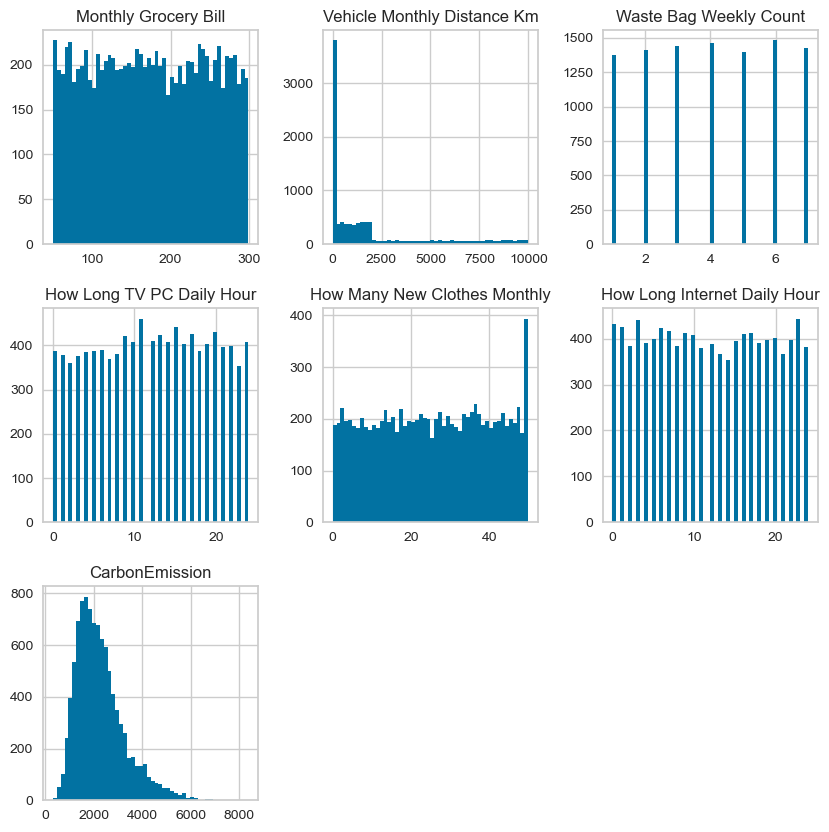

In [12]:
# Plotting the distribution of the numeric values:
df_nums.hist(figsize=(10, 10), bins=50,)

<Axes: >

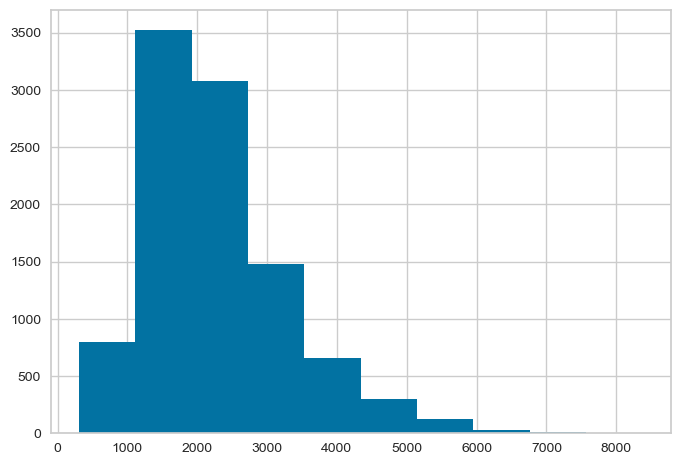

In [13]:
# Viewing the distribution of the target variable:
df_nums['CarbonEmission'].hist()

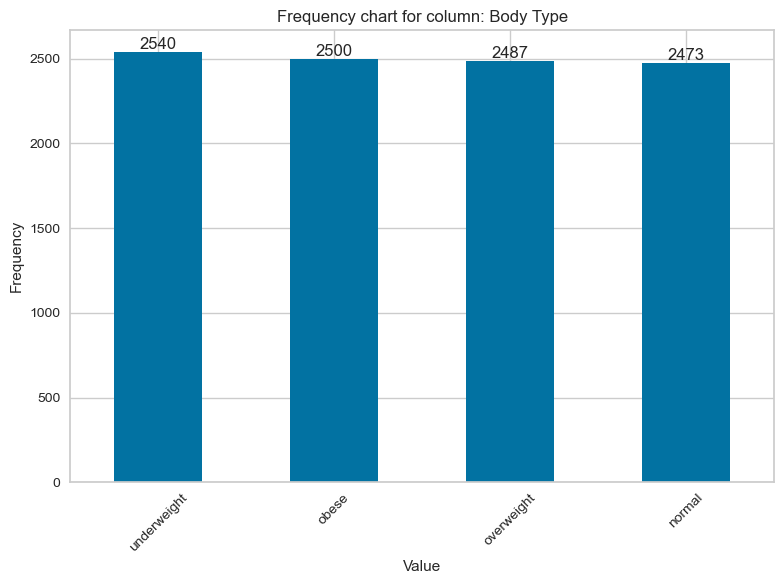

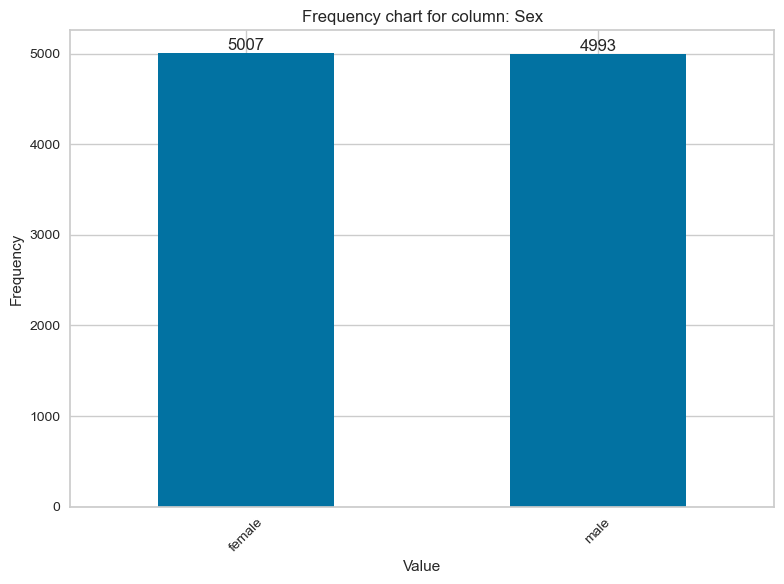

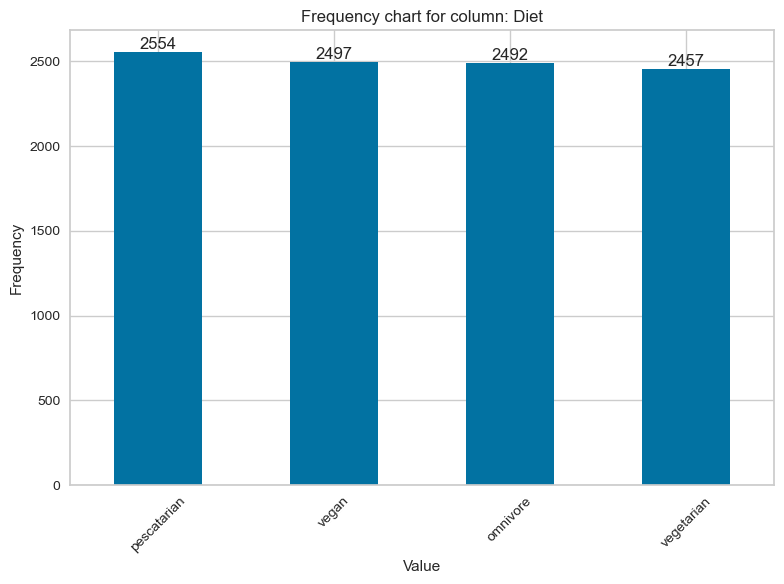

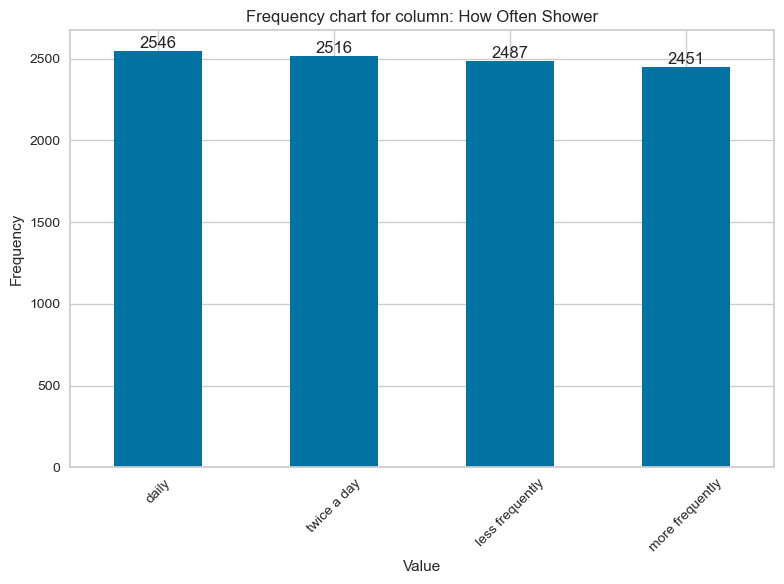

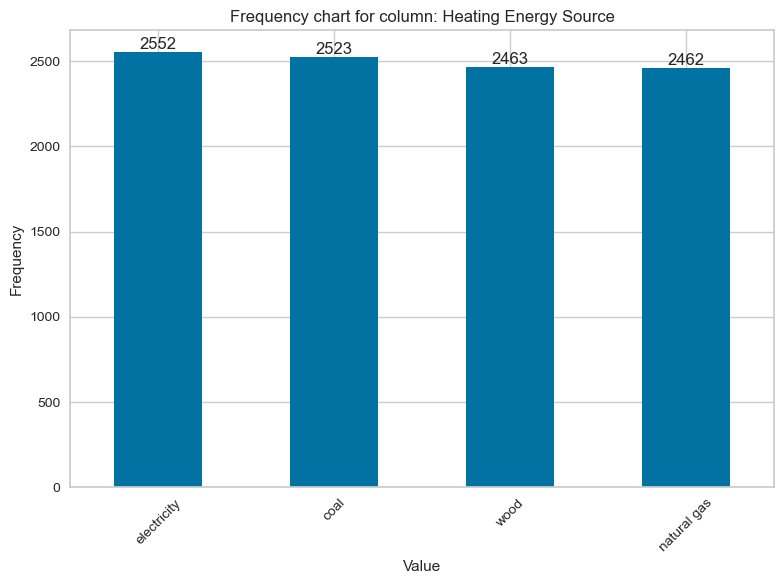

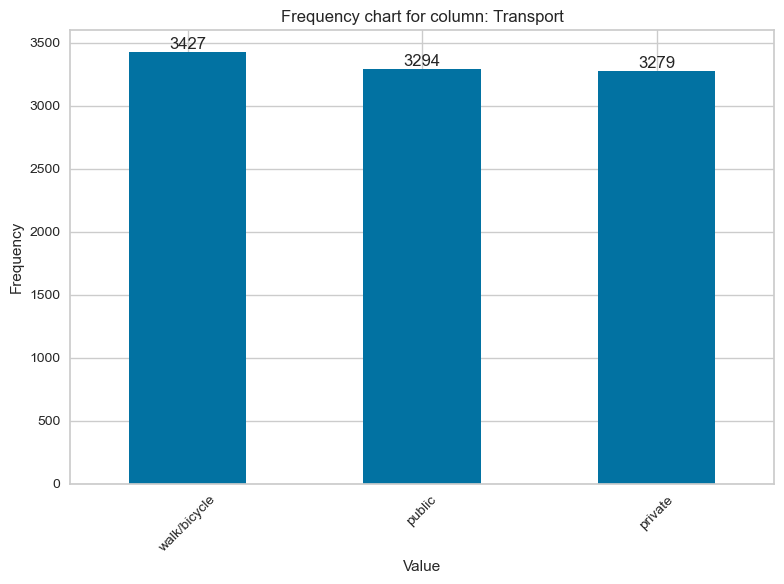

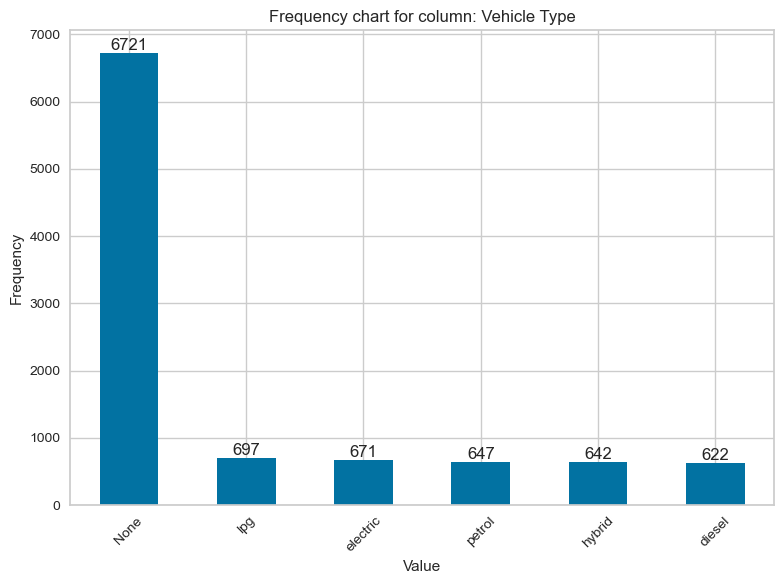

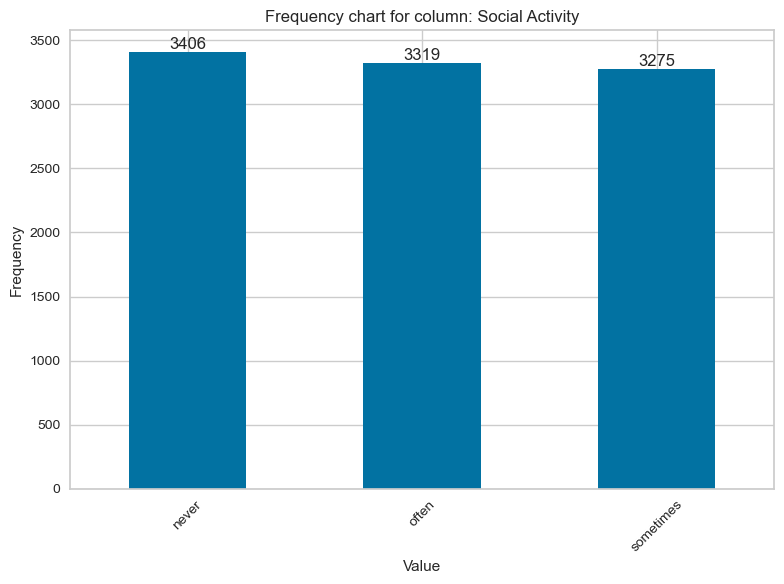

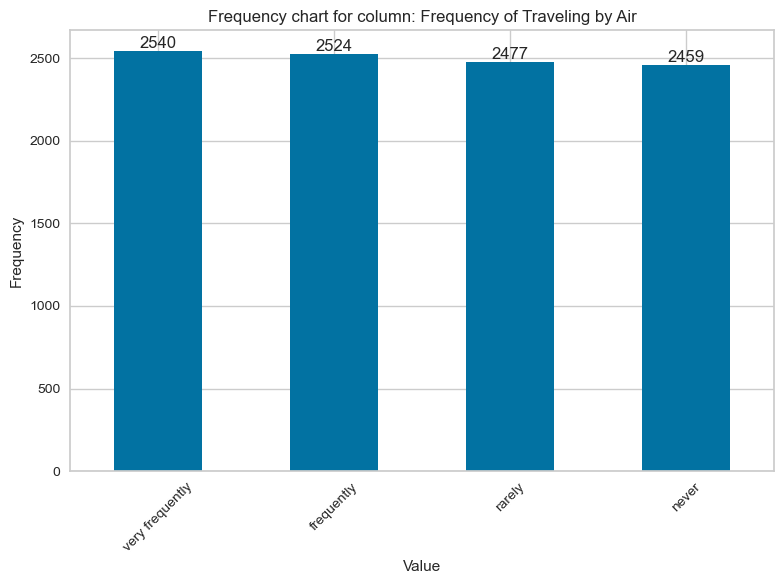

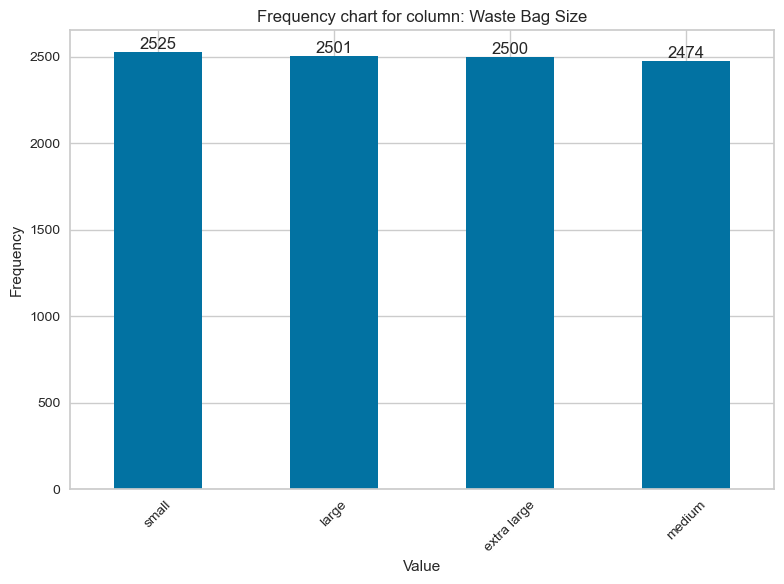

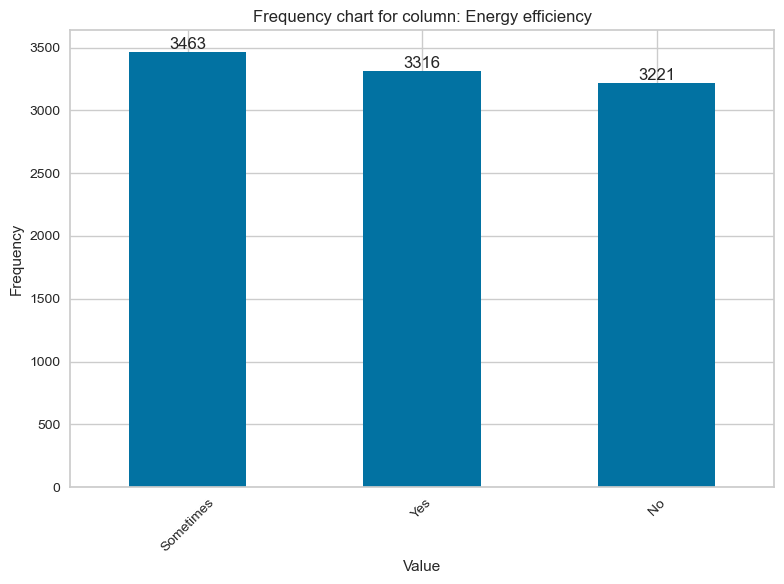

In [14]:
# Frequency chart for columns:
selected_columns = df.select_dtypes(include=['object']).columns[: -2]

frequency_count_list = {}

for col in selected_columns:
    counts = df[col].value_counts()
    frequency_count_list[col] = counts

for column, counts in frequency_count_list.items(): 
    plt.figure(figsize=(8, 6))
    counts.plot(kind='bar')
    plt.title(f"Frequency chart for column: {column}")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)

    for i, v in enumerate(counts):
        plt.text(i, v, str(v), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

### Data cleaning and exploration

It looks like it follows a kind of skewed normal distribution, with a few outliers lying greatly above the mean

In [15]:
# Encode/transform data numeric
encoder = OrdinalEncoder(dtype=np.int64)

# Making copy of df to a new dataframe called: df_numeric 
df_numeric = df.copy()

# Gettning all columns that has object type:
cate_columns = df.select_dtypes(include=['object']).columns

df_numeric[cate_columns] = encoder.fit_transform(df[cate_columns])

In [16]:
# Verifying that cols have been encoded:
df_numeric.sample(5)

,Body Type,Sex,Diet,How Often Shower,Heating Energy Source,Transport,Vehicle Type,Social Activity,Monthly Grocery Bill,Frequency of Traveling by Air,Vehicle Monthly Distance Km,Waste Bag Size,Waste Bag Weekly Count,How Long TV PC Daily Hour,How Many New Clothes Monthly,How Long Internet Daily Hour,Energy efficiency,Recycling,Cooking_With,CarbonEmission
7816,2,0,1,2,0,1,0,0,192,2,406,3,2,7,29,0,1,13,10,1368
9644,1,1,2,1,1,2,0,2,183,3,71,1,4,14,39,20,2,9,15,3181
9955,3,0,3,0,3,0,3,1,177,3,1786,1,3,3,18,16,2,15,5,2461
7181,1,0,2,1,2,2,0,2,222,0,24,2,1,11,21,0,0,5,3,1515
3486,1,1,3,3,0,1,0,0,191,1,1864,0,6,20,9,20,1,12,8,2443


In [17]:
print(cate_columns)

Index(['Body Type', 'Sex', 'Diet', 'How Often Shower', 'Heating Energy Source',
       'Transport', 'Vehicle Type', 'Social Activity',
       'Frequency of Traveling by Air', 'Waste Bag Size', 'Energy efficiency',
       'Recycling', 'Cooking_With'],
      dtype='object')


In [18]:
df_numeric.dtypes

Body Type                        int64
Sex                              int64
Diet                             int64
How Often Shower                 int64
Heating Energy Source            int64
Transport                        int64
Vehicle Type                     int64
Social Activity                  int64
Monthly Grocery Bill             int64
Frequency of Traveling by Air    int64
Vehicle Monthly Distance Km      int64
Waste Bag Size                   int64
Waste Bag Weekly Count           int64
How Long TV PC Daily Hour        int64
How Many New Clothes Monthly     int64
How Long Internet Daily Hour     int64
Energy efficiency                int64
Recycling                        int64
Cooking_With                     int64
CarbonEmission                   int64
dtype: object

In [19]:
# save Label encoding
with open('models/encoder.pkl', 'wb') as file:
    pickle.dump(encoder, file)


In [20]:
corr_matrix = df_numeric.corr()

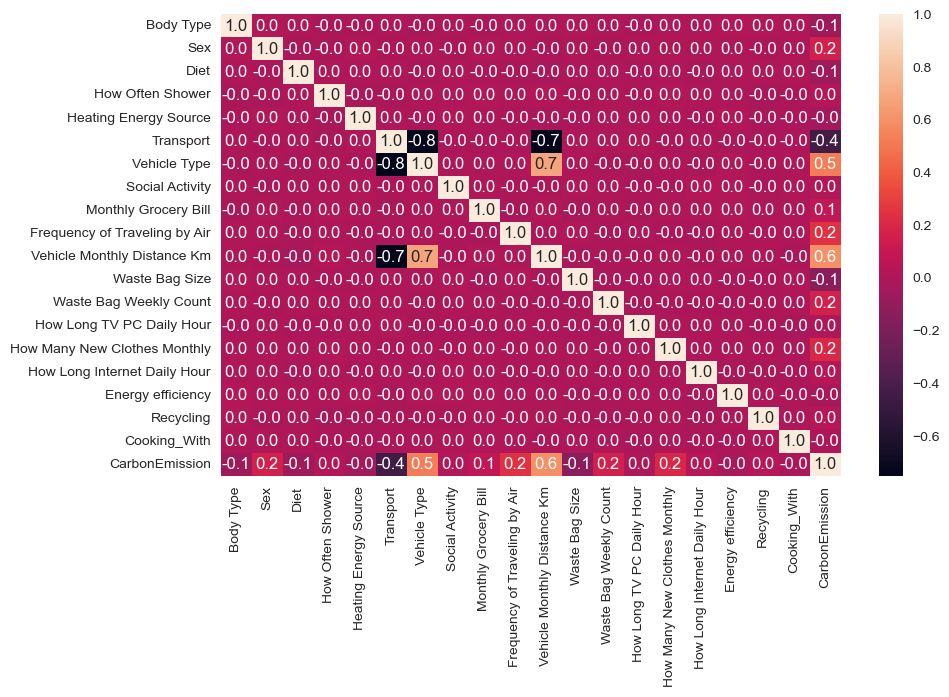

In [21]:
# Heatmap that can show correlation
plt.figure(figsize=(10,6))
sns.heatmap(corr_matrix, annot=True, fmt=".1f")
plt.show()

The biggest correlation with carbon emissions, seem to be the monthly travelled distance by personal vehicle. Other factor with clear correlations seem to be type of transport, vehicle type and frequency of travelling with airplane. There also seem to be a smaller correlation with the amount of clothes people buy.

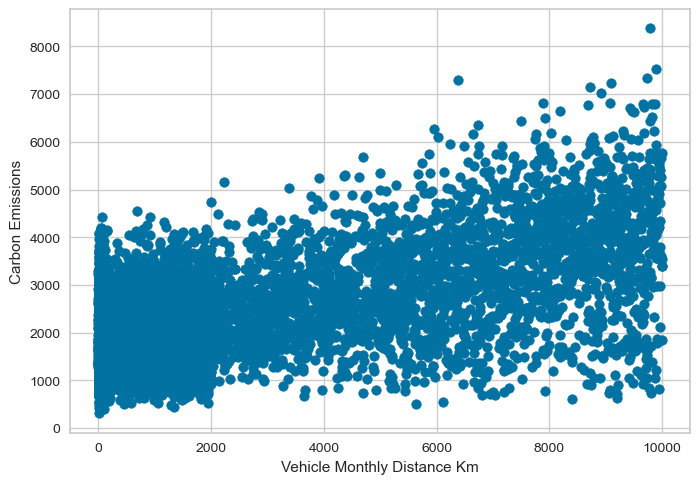

In [22]:
plt.xlabel('Vehicle Monthly Distance Km')
plt.ylabel('Carbon Emissions')
plt.scatter(df_numeric['Vehicle Monthly Distance Km'], df_numeric['CarbonEmission'])
plt.show()

Does internet usage have an impact on carbon emissions?

In [23]:
corr_matrix['CarbonEmission']['How Long Internet Daily Hour']

0.043878026391883734

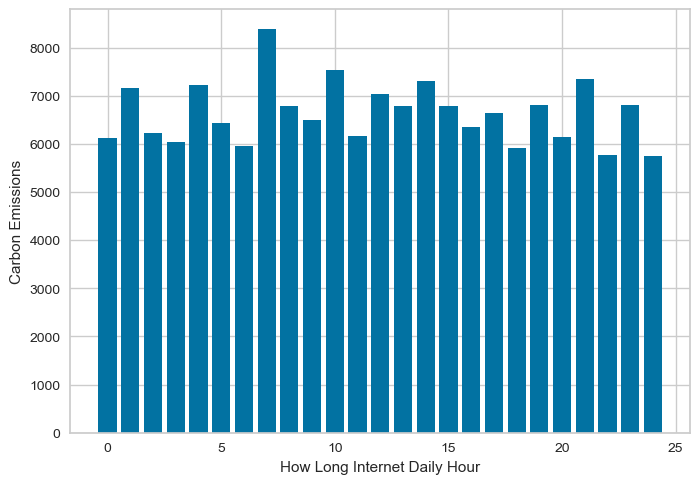

In [24]:
plt.xlabel('How Long Internet Daily Hour')
plt.ylabel('Carbon Emissions')
plt.bar(df_numeric['How Long Internet Daily Hour'], df_numeric['CarbonEmission'])
plt.show()

There is a slight correlation, but nowhere near enough to asser any tendencies. We are lucky computer people!

Let's see if theres as difference between male an female patterns

In [25]:
# Split dataframe based on sex, and see if theres a difference in the correlation
df_male = df_numeric[df_numeric['Sex'] == 1]
df_male

,Body Type,Sex,Diet,How Often Shower,Heating Energy Source,Transport,Vehicle Type,Social Activity,Monthly Grocery Bill,Frequency of Traveling by Air,Vehicle Monthly Distance Km,Waste Bag Size,Waste Bag Weekly Count,How Long TV PC Daily Hour,How Many New Clothes Monthly,How Long Internet Daily Hour,Energy efficiency,Recycling,Cooking_With,CarbonEmission
2,2,1,0,2,3,0,5,0,138,1,2472,3,1,14,47,6,1,2,5,2595
3,2,1,0,3,3,2,0,2,157,2,74,2,3,20,5,7,1,6,1,1074
5,2,1,3,1,3,1,0,2,144,0,658,1,1,22,18,9,1,3,12,1647
8,2,1,0,0,3,1,0,0,200,0,1376,2,3,3,31,15,2,1,1,2494
11,1,1,3,2,0,2,0,0,111,3,69,2,5,9,4,4,1,15,12,3226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9992,1,1,0,2,0,1,0,0,120,2,421,1,3,10,33,6,2,9,7,2077
9993,3,1,1,2,3,2,0,2,118,0,78,2,3,8,14,10,1,15,6,1794
9995,1,1,0,3,0,0,3,2,230,1,268,2,5,12,27,9,2,15,2,2408
9998,3,1,2,2,0,0,5,1,179,2,8688,2,5,19,14,5,1,5,8,4574


In [26]:
df_female = df_numeric[df_numeric['Sex'] == 0]
df_female

,Body Type,Sex,Diet,How Often Shower,Heating Energy Source,Transport,Vehicle Type,Social Activity,Monthly Grocery Bill,Frequency of Traveling by Air,Vehicle Monthly Distance Km,Waste Bag Size,Waste Bag Weekly Count,How Long TV PC Daily Hour,How Many New Clothes Monthly,How Long Internet Daily Hour,Energy efficiency,Recycling,Cooking_With,CarbonEmission
0,2,0,1,0,0,1,0,1,230,0,210,1,4,7,26,1,0,2,13,2238
1,1,0,3,1,2,2,0,1,114,2,9,0,3,9,38,5,0,2,9,1892
4,1,0,3,0,0,0,1,1,266,3,8457,1,1,3,5,6,2,10,6,4743
6,3,0,2,1,3,0,3,0,56,2,5363,2,4,9,11,19,1,15,0,1832
7,3,0,2,2,0,2,0,2,59,3,54,0,3,5,39,15,0,7,9,2322
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9990,3,0,0,2,1,1,0,2,226,0,755,2,7,16,17,4,2,8,9,1412
9991,1,0,0,2,0,2,0,0,55,2,82,2,2,19,10,11,1,0,2,1278
9994,0,0,3,2,3,0,5,0,89,2,4482,1,5,15,17,22,1,15,5,2999
9996,0,0,2,3,0,0,4,0,234,0,5316,0,3,14,8,24,1,9,9,3084


In [27]:
df_male_corr = df_male.corr()
df_female_corr = df_female.corr()

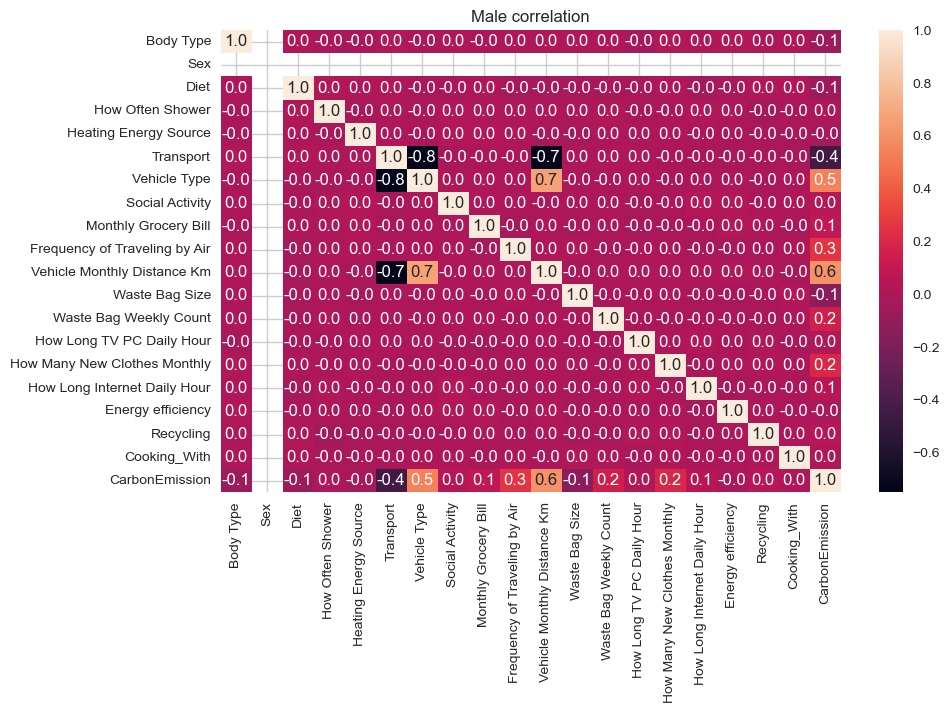

In [28]:
plt.figure(figsize=(10,6))
sns.heatmap(df_male_corr, annot=True, fmt=".1f")
plt.title('Male correlation')
plt.show()

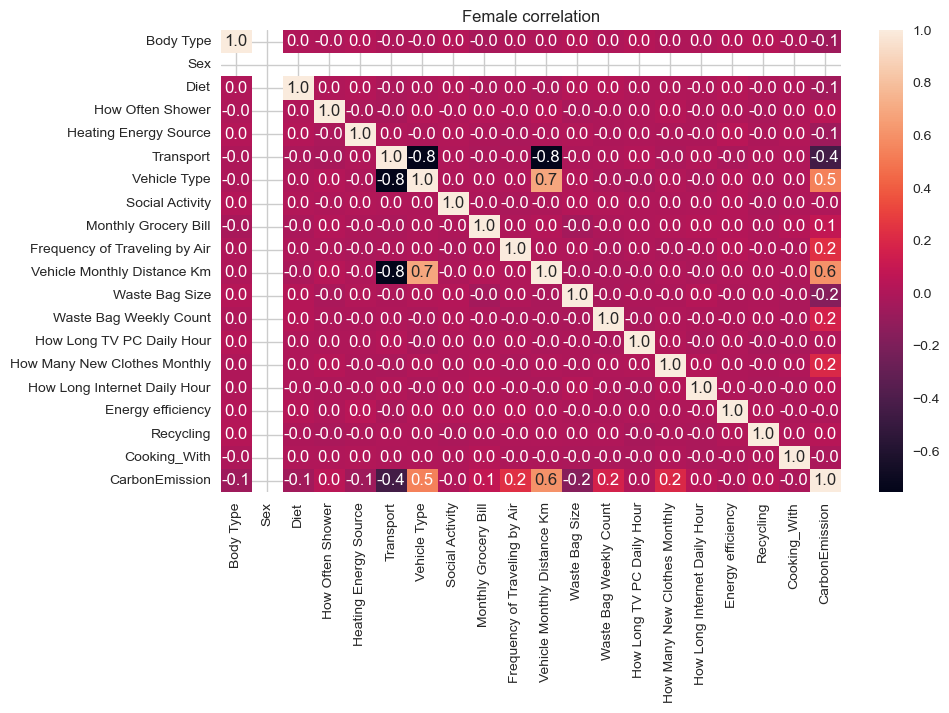

In [29]:
plt.figure(figsize=(10,6))
sns.heatmap(df_female_corr, annot=True, fmt=".1f")
plt.title('Female correlation')
plt.show()

There doesn't really seem to be a difference of how much the factors weigh between males and females

### Outliers

<Axes: >

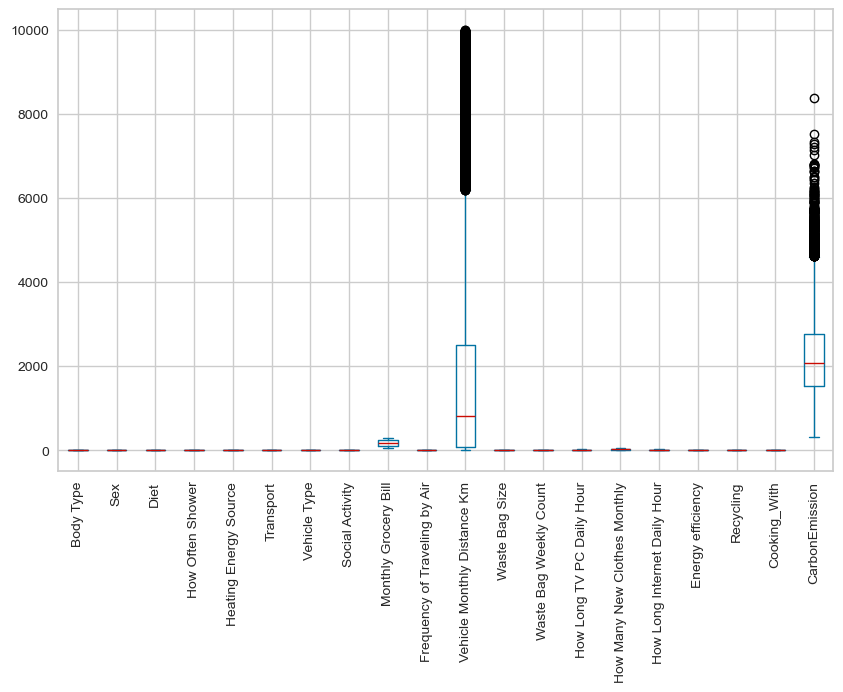

In [30]:
df_numeric.plot.box(rot=90, figsize=(10,6))

<Axes: >

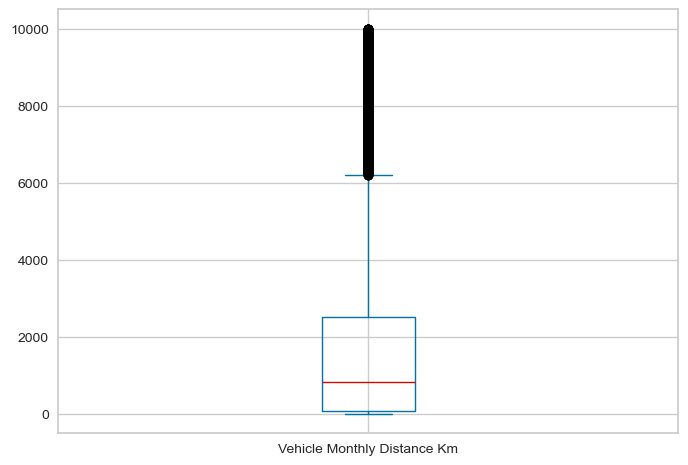

In [31]:
df_nums['Vehicle Monthly Distance Km'].plot.box()

In [32]:
med = df_nums['Vehicle Monthly Distance Km'].median()
df_nums['Vehicle Monthly Distance Km'].max() - med

9176.0

As we can see, the distribution of distance travelled by vehicle is very skewed, with 75% of the data lying beneath 3000 km pr month, with quite a few outlier being outragerously above the median. This might still be an accurate representation though, since some individuals just might travel that much. 
We'll keep it for the variance

Let's see if people are as accurate as they think, when they say they're energy efficient!

In [33]:
test = df_numeric.iloc[[6550]]
test

,Body Type,Sex,Diet,How Often Shower,Heating Energy Source,Transport,Vehicle Type,Social Activity,Monthly Grocery Bill,Frequency of Traveling by Air,Vehicle Monthly Distance Km,Waste Bag Size,Waste Bag Weekly Count,How Long TV PC Daily Hour,How Many New Clothes Monthly,How Long Internet Daily Hour,Energy efficiency,Recycling,Cooking_With,CarbonEmission
6550,3,1,2,3,3,2,0,2,157,3,13,3,2,20,45,12,2,3,2,2372


In [34]:
grouped_data = df.groupby('Energy efficiency')

grouped = df.groupby('Energy efficiency')['CarbonEmission'].agg(['mean', 'sum']).reset_index()
grouped

,Energy efficiency,mean,sum
0,No,2286.656628,7365321
1,Sometimes,2269.151314,7858071
2,Yes,2252.135404,7468081


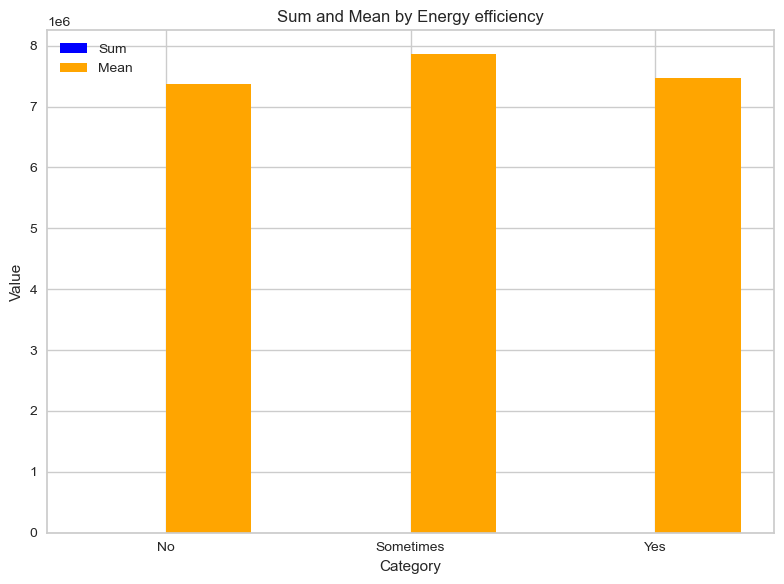

In [35]:
plt.figure(figsize=(8, 6))

# Define the width of each bar
bar_width = 0.35

# Define the positions for the bars
index = np.arange(len(grouped['Energy efficiency']))

# Create side-by-side bars for 'Sum' and 'Mean'
plt.bar(index, grouped['mean'], bar_width, color='blue', label='Sum')
plt.bar(index + bar_width, grouped['sum'], bar_width, color='orange', label='Mean')

# Add labels, title, and legend
plt.xlabel('Category')
plt.ylabel('Value')
plt.title('Sum and Mean by Energy efficiency')
plt.xticks(index + bar_width / 2, grouped['Energy efficiency'])
plt.legend()

plt.tight_layout()
plt.show()

<Axes: xlabel='Energy efficiency'>

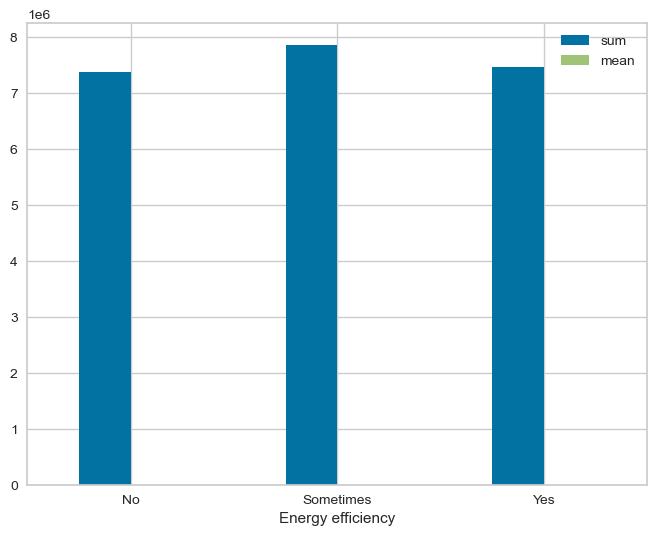

In [36]:
grouped['sum'] = grouped['sum'].astype(float)
grouped['mean'] = grouped['mean'].astype(float)
grouped.plot.bar(x='Energy efficiency', y=['sum','mean'], figsize=(8, 6), rot=0)

We can see that people say that the are energy efficient generally tend to have a little bit lower carbon emission in total, but the difference really is only about 1,5% lower than the 'No' category.

The total sum of carbon emissions seems to be higher by people declaring that they're being energy efficient, indicating that a lot more people think they are being efficient than not, while not really making any difference in the emitted carbon dioxide!

### Plane travel

We can see theres a small correlation between the Frequency of air travel, and their carbon emission, let's sxplore what it means

In [37]:
group_air = df.groupby('Frequency of Traveling by Air').size().reset_index(name='Count')
group_air

,Frequency of Traveling by Air,Count
0,frequently,2524
1,never,2459
2,rarely,2477
3,very frequently,2540


<Axes: ylabel='Count'>

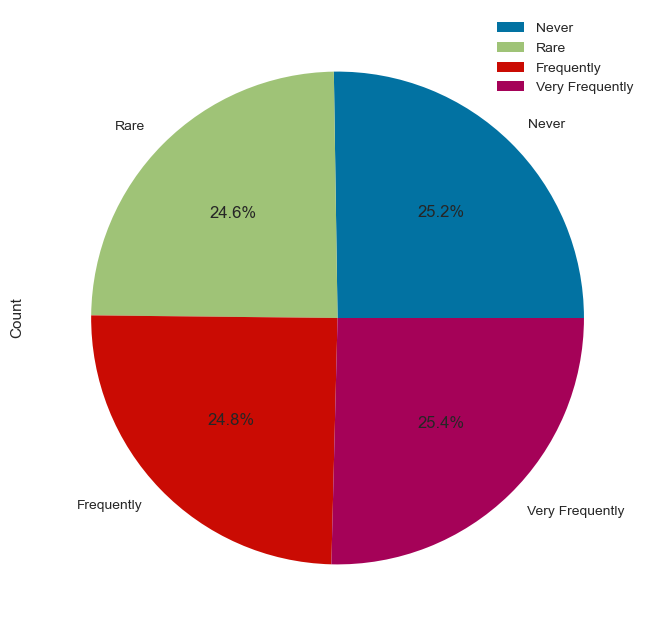

In [38]:
# Plot the distribution of the frequency
group_air.plot.pie(y='Count', labels=['Never', 'Rare', 'Frequently', 'Very Frequently'], autopct='%1.1f%%', figsize=(8, 8))

In [39]:
grouped = df.groupby('Frequency of Traveling by Air')['CarbonEmission'].agg(['mean', 'sum']).reset_index()
grouped

,Frequency of Traveling by Air,mean,sum
0,frequently,2362.866482,5963875
1,never,1716.337129,4220473
2,rarely,1945.872830,4819927
3,very frequently,3026.455906,7687198


Total mean = 2262.8

total mean / very frequently = 0.75

Very frequently travelers emit around 25% on average than the average across all flight travel categories

<Axes: xlabel='Frequency of Traveling by Air'>

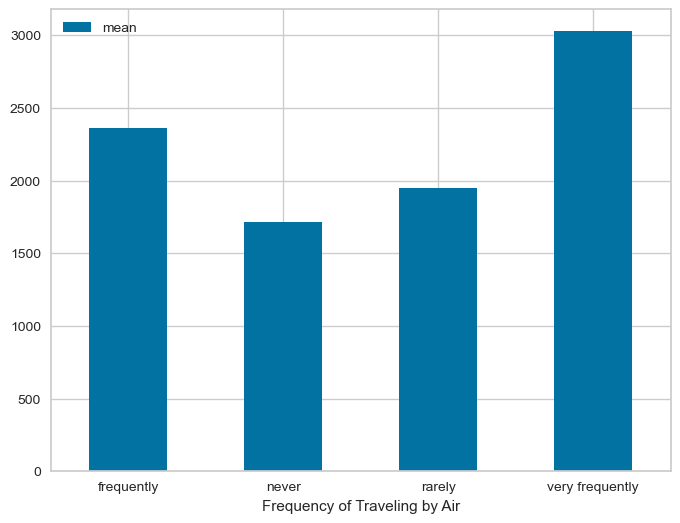

In [40]:
grouped.plot.bar(x='Frequency of Traveling by Air', y=['mean'], figsize=(8, 6), rot=0)

As we can see, the distribution of people is fairly equal between all different categories of flight frequency, but there's a clearly tendency of higher average carbon emissions from people who are in the 'very frequent' category.

The mean carbon emssions are around 22% higher for people who travel very frequently by air.


## Supervised Machine learning

Let's try and see if we can predict total carbon emission values by training different classifier models.
Since we're doing classification, we'll bin the carbon emission numbers into categories

In [41]:
df_numeric.sample(5)

,Body Type,Sex,Diet,How Often Shower,Heating Energy Source,Transport,Vehicle Type,Social Activity,Monthly Grocery Bill,Frequency of Traveling by Air,Vehicle Monthly Distance Km,Waste Bag Size,Waste Bag Weekly Count,How Long TV PC Daily Hour,How Many New Clothes Monthly,How Long Internet Daily Hour,Energy efficiency,Recycling,Cooking_With,CarbonEmission
9868,1,0,2,2,2,2,0,0,220,1,21,3,7,17,29,24,2,10,9,1442
2961,2,0,2,0,2,0,1,2,131,0,8754,1,6,22,3,17,0,4,8,3959
9626,3,0,2,0,1,2,0,0,153,1,91,3,4,24,28,10,1,4,0,657
5450,1,1,0,0,2,0,2,0,221,1,5608,2,1,4,12,9,1,13,3,1236
432,1,0,3,2,2,1,0,0,123,1,1795,0,3,19,27,23,1,6,0,1374


In [42]:
df_numeric.columns

Index(['Body Type', 'Sex', 'Diet', 'How Often Shower', 'Heating Energy Source',
       'Transport', 'Vehicle Type', 'Social Activity', 'Monthly Grocery Bill',
       'Frequency of Traveling by Air', 'Vehicle Monthly Distance Km',
       'Waste Bag Size', 'Waste Bag Weekly Count', 'How Long TV PC Daily Hour',
       'How Many New Clothes Monthly', 'How Long Internet Daily Hour',
       'Energy efficiency', 'Recycling', 'Cooking_With', 'CarbonEmission'],
      dtype='object')

In [43]:
scaled_data = df_numeric[['CarbonEmission']]

In [44]:
qtrans = QuantileTransformer(output_distribution='normal', random_state=0)
scaled_data['CarbonEmission_trans_norm'] = qtrans.fit_transform(scaled_data[['CarbonEmission']])

print('Mean:', scaled_data['CarbonEmission_trans_norm'].mean())
print('Standard Deviation:', scaled_data['CarbonEmission_trans_norm'].std())

Mean: -5.7164614667183854e-05
Standard Deviation: 1.0008721999469523


In [45]:
scaled_data.describe()

,CarbonEmission,CarbonEmission_trans_norm
count,10000.000000,10000.000000
mean,2269.147300,-0.000057
std,1017.675247,1.000872
min,306.000000,-5.199338
25%,1538.000000,-0.673702
50%,2080.000000,0.000000
75%,2768.000000,0.675027
max,8377.000000,5.199338


In [46]:
df_part = df_numeric.copy().drop(columns=['CarbonEmission'], axis=1)
df_bin = pd.concat([df_part, scaled_data['CarbonEmission_trans_norm']], axis=1)
df_bin

,Body Type,Sex,Diet,How Often Shower,Heating Energy Source,Transport,Vehicle Type,Social Activity,Monthly Grocery Bill,Frequency of Traveling by Air,Vehicle Monthly Distance Km,Waste Bag Size,Waste Bag Weekly Count,How Long TV PC Daily Hour,How Many New Clothes Monthly,How Long Internet Daily Hour,Energy efficiency,Recycling,Cooking_With,CarbonEmission_trans_norm
0,2,0,1,0,0,1,0,1,230,0,210,1,4,7,26,1,0,2,13,0.165943
1,1,0,3,1,2,2,0,1,114,2,9,0,3,9,38,5,0,2,9,-0.200818
2,2,1,0,2,3,0,5,0,138,1,2472,3,1,14,47,6,1,2,5,0.519512
3,2,1,0,3,3,2,0,2,157,2,74,2,3,20,5,7,1,6,1,-1.497997
4,1,0,3,0,0,0,1,1,266,3,8457,1,1,3,5,6,2,10,6,1.883938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1,1,0,3,0,0,3,2,230,1,268,2,5,12,27,9,2,15,2,0.336178
9996,0,0,2,3,0,0,4,0,234,0,5316,0,3,14,8,24,1,9,9,0.925534
9997,2,0,3,0,1,2,0,2,298,3,96,0,5,11,5,24,2,8,1,0.303402
9998,3,1,2,2,0,0,5,1,179,2,8688,2,5,19,14,5,1,5,8,1.794943


In [47]:
emission_max = df_bin['CarbonEmission_trans_norm'].max()
emission_min = df_bin['CarbonEmission_trans_norm'].min()

bins = np.linspace(emission_min -1, emission_max, 5)

df_bin['EmissionBin'] = pd.qcut(df_bin['CarbonEmission_trans_norm'], q=4, labels=False)
df_bin.describe()


,Body Type,Sex,Diet,How Often Shower,Heating Energy Source,Transport,Vehicle Type,Social Activity,Monthly Grocery Bill,Frequency of Traveling by Air,...,Waste Bag Size,Waste Bag Weekly Count,How Long TV PC Daily Hour,How Many New Clothes Monthly,How Long Internet Daily Hour,Energy efficiency,Recycling,Cooking_With,CarbonEmission_trans_norm,EmissionBin
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,1.509400,0.499300,1.491900,1.493700,1.486500,1.014800,0.991300,0.98690,173.875200,1.503300,...,1.502400,4.024600,12.139200,25.109000,11.889100,1.009500,7.542100,7.514400,-0.000057,1.498500
std,1.119213,0.500025,1.113489,1.123604,1.116755,0.818809,1.630549,0.81731,72.234018,1.123795,...,1.120321,1.990375,7.106369,14.698725,7.277218,0.808502,4.629295,4.583611,1.000872,1.118178
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,50.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-5.199338,0.000000
25%,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.00000,111.000000,0.000000,...,0.750000,2.000000,6.000000,13.000000,6.000000,0.000000,3.000000,4.000000,-0.673702,0.000000
50%,2.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000,173.000000,2.000000,...,1.000000,4.000000,12.000000,25.000000,12.000000,1.000000,8.000000,8.000000,0.000000,1.000000
75%,3.000000,1.000000,2.000000,3.000000,2.000000,2.000000,2.000000,2.00000,237.000000,3.000000,...,3.000000,6.000000,18.000000,38.000000,18.000000,2.000000,12.000000,12.000000,0.675027,2.000000
max,3.000000,1.000000,3.000000,3.000000,3.000000,2.000000,5.000000,2.00000,299.000000,3.000000,...,3.000000,7.000000,24.000000,50.000000,24.000000,2.000000,15.000000,15.000000,5.199338,3.000000


In [48]:
grouped_bin = df_bin.groupby('EmissionBin').size().reset_index(name='Count')
grouped_bin

,EmissionBin,Count
0,0,2506
1,1,2498
2,2,2501
3,3,2495


In [49]:
df_bin.drop('CarbonEmission_trans_norm', axis=1, inplace=True)
df_bin.sample(5)

,Body Type,Sex,Diet,How Often Shower,Heating Energy Source,Transport,Vehicle Type,Social Activity,Monthly Grocery Bill,Frequency of Traveling by Air,Vehicle Monthly Distance Km,Waste Bag Size,Waste Bag Weekly Count,How Long TV PC Daily Hour,How Many New Clothes Monthly,How Long Internet Daily Hour,Energy efficiency,Recycling,Cooking_With,EmissionBin
6713,2,1,3,1,0,2,0,2,179,1,33,3,6,1,27,12,1,9,2,0
405,3,0,1,2,1,2,0,2,198,2,91,1,7,16,13,8,1,6,13,0
665,2,0,0,3,3,2,0,0,79,2,46,0,1,21,21,16,1,0,3,0
7716,2,1,2,0,1,2,0,0,223,3,76,3,6,21,8,23,2,13,2,2
5308,1,1,0,0,1,0,3,2,105,3,7567,3,6,20,35,8,2,4,1,3


## Prediction by classification

#### Naive Bayes model

In [50]:
df_bin.head()

,Body Type,Sex,Diet,How Often Shower,Heating Energy Source,Transport,Vehicle Type,Social Activity,Monthly Grocery Bill,Frequency of Traveling by Air,Vehicle Monthly Distance Km,Waste Bag Size,Waste Bag Weekly Count,How Long TV PC Daily Hour,How Many New Clothes Monthly,How Long Internet Daily Hour,Energy efficiency,Recycling,Cooking_With,EmissionBin
0,2,0,1,0,0,1,0,1,230,0,210,1,4,7,26,1,0,2,13,2
1,1,0,3,1,2,2,0,1,114,2,9,0,3,9,38,5,0,2,9,1
2,2,1,0,2,3,0,5,0,138,1,2472,3,1,14,47,6,1,2,5,2
3,2,1,0,3,3,2,0,2,157,2,74,2,3,20,5,7,1,6,1,0
4,1,0,3,0,0,0,1,1,266,3,8457,1,1,3,5,6,2,10,6,3


In [51]:
# Convert the dataset into array
array = df_bin.values
# Create two axis for the test data
X = array[:,0:19] 
Y = array[:,-1]   # CarbonEmission
Y

array([2, 1, 2, ..., 2, 3, 0], dtype=int64)

In [52]:
# split proportion
test_set_size = 0.15

# Initial value for randomization
seed = 42 # this is the answer
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=test_set_size, random_state=seed)

In [53]:
# Use GaussianNB for numeric data
nb = GaussianNB()
nb.fit(X_train, Y_train)

GaussianNB()

In [54]:
# test the model
nb.score(X_test, Y_test)

0.54

An accuracy of about 70 percent, not bad for a first try, but I think we can do better.
Let's try to focus on the correlating values

In [55]:
column_indexes = ['Body Type', 'Diet', 'How Often Shower', 'Heating Energy Source',
       'Transport', 'Social Activity', 'Monthly Grocery Bill',
       'Frequency of Traveling by Air', 'Vehicle Monthly Distance Km',
       'Waste Bag Size', 'Waste Bag Weekly Count',
       'How Many New Clothes Monthly'] # Columns with correlation > 0.1
df_features = df_numeric[column_indexes]
df_features.columns

Index(['Body Type', 'Diet', 'How Often Shower', 'Heating Energy Source',
       'Transport', 'Social Activity', 'Monthly Grocery Bill',
       'Frequency of Traveling by Air', 'Vehicle Monthly Distance Km',
       'Waste Bag Size', 'Waste Bag Weekly Count',
       'How Many New Clothes Monthly'],
      dtype='object')

In [56]:
X = df_numeric[column_indexes].values
X


array([[ 2,  1,  0, ...,  1,  4, 26],
       [ 1,  3,  1, ...,  0,  3, 38],
       [ 2,  0,  2, ...,  3,  1, 47],
       ...,
       [ 2,  3,  0, ...,  0,  5,  5],
       [ 3,  2,  2, ...,  2,  5, 14],
       [ 1,  1,  3, ...,  3,  4,  6]], dtype=int64)

In [57]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=test_set_size, random_state=seed)
Y_test.shape

(1500,)

In [58]:
nb = GaussianNB()
nb.fit(X_train, Y_train)

GaussianNB()

#### Validation

In [59]:
prediction = nb.predict(X_test)
prediction

array([0, 1, 1, ..., 2, 2, 3], dtype=int64)

In [60]:
print(accuracy_score(Y_test, prediction))

0.5666666666666667


In [61]:
cmat = confusion_matrix(Y_test, prediction)
print(cmat)
print(classification_report(Y_test, prediction))

[[279  47   5  25]
 [117 180  57  41]
 [  5 127 153  82]
 [  0  21 123 238]]
              precision    recall  f1-score   support

           0       0.70      0.78      0.74       356
           1       0.48      0.46      0.47       395
           2       0.45      0.42      0.43       367
           3       0.62      0.62      0.62       382

    accuracy                           0.57      1500
   macro avg       0.56      0.57      0.56      1500
weighted avg       0.56      0.57      0.56      1500



In the end, it made a bigger difference to adjust the test set size to around 15% of the set

### Decision Tree Classifier

In [62]:
test_set_size = 0.15
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=test_set_size, random_state=seed)
Y_test.shape

(1500,)

In [63]:
# Build Decision Trees Classifier 
params = {'max_depth': 6}
treeM = DecisionTreeClassifier(**params)
treeM.fit(X_train, Y_train)

DecisionTreeClassifier(max_depth=6)

In [64]:
gr_data = tree.export_graphviz(treeM, out_file=None, 
                         feature_names=df_features.columns, class_names = True,        
                         filled=True, rounded=True, proportion = False, special_characters=True)  
dtree = graphviz.Source(gr_data)

In [65]:
# render the tree as pdf
dtree.render('dtree_render', format='pdf', cleanup=True)

'dtree_render.pdf'

#### Validation

In [66]:
y_predict = treeM.predict(X_test)
y_predict

array([0, 1, 2, ..., 3, 3, 3], dtype=int64)

In [67]:
cmat = confusion_matrix(Y_test, y_predict)
print(cmat)
print(classification_report(Y_test, y_predict))

[[243  88   7  18]
 [107 179  85  24]
 [  9  86 201  71]
 [  2  10 106 264]]
              precision    recall  f1-score   support

           0       0.67      0.68      0.68       356
           1       0.49      0.45      0.47       395
           2       0.50      0.55      0.52       367
           3       0.70      0.69      0.70       382

    accuracy                           0.59      1500
   macro avg       0.59      0.59      0.59      1500
weighted avg       0.59      0.59      0.59      1500



Even better than before. Maybe our predictions can be even more accurate by using several decision trees

### Random Forest Classifier

In [68]:
test_set_size = 0.15
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=test_set_size, random_state=seed)
Y_test.shape

(1500,)

In [69]:
forest = RandomForestClassifier(n_estimators = 300, max_depth = 13)
forest.fit(X_train, Y_train)

RandomForestClassifier(max_depth=13, n_estimators=300)

#### Validation

In [70]:
y_predict = forest.predict(X_test)
y_predict

array([0, 1, 1, ..., 3, 3, 3], dtype=int64)

In [71]:
cmat = confusion_matrix(Y_test, y_predict)
print(cmat)
print(classification_report(Y_test, y_predict))

[[284  49   6  17]
 [ 95 211  66  23]
 [  5  76 206  80]
 [  1   3  75 303]]
              precision    recall  f1-score   support

           0       0.74      0.80      0.77       356
           1       0.62      0.53      0.57       395
           2       0.58      0.56      0.57       367
           3       0.72      0.79      0.75       382

    accuracy                           0.67      1500
   macro avg       0.66      0.67      0.67      1500
weighted avg       0.66      0.67      0.67      1500



In [72]:
pickle.dump(forest, open('./models/forest_model.pkl', 'wb'))

### Classification summary

**Iteration 1**
- No data normalization
- 5 equally divided bins <br />

80% accuracy (RFC)

At 80% accuracy the random forest classifier seems to be the most accurate model we have tested. It seems to correctly categorize a lot of the lower emitting categories, and is a little less accurate on cases with fewer instances. It's still making some big mistakes which might not show up in the overall calculated score, but is very significant.
For example, none of the models have succesfully caught any people in the topmost carbon emitting category. Perhaps implying, that the category data sould be binned differently, becuase if only very few instances fit into the bin, the model might not have any chance of recieving enough training data to be able to recognize the extreme cases.

**Iteration 2**
- Data transformed to normal distribution
- 4 equally divided bins

87% accuracy (RFC).

Model accuracy have improved in accuracy. I accredit this to the fewer bins and the now normal distribution of the data. Even though the accuracy seems higher, the result is still unsatisfactory since it fails to identify any extreme cases in both high and low end. Because of the normal distribution transform, the data have accumulated around the mean, resulting in only around 2% of the data fitting in the extreme bins. The training data might still be to sparse to let the model identify these few extreme cases

**Iteration 3**
- Data transformed to normal distribution
- 3 equally divided bins

92% accuracy (RFC)

Model have once model improved in accuracy. Even with only 3 bins, the middle bin is responsible for 92% of the data. The fewer amount of bins, gives better results when identifying outlier cases, but it is still very overfitted and not very useful

**Iteration 4**
- Data transformed to normal distribution
- 4 bins divided by quantiles

67% accuracy (RFC)

Accuracy has dropped to 67%, but seems to catch a lot more of the extreme cases, now the bin sizes have been adjusted. It now represents the data tendencies way better, and are less overfitted.



## Prediction by regression

### XGBregressor

In [73]:
# Selecting the features (x) and the target (y)
ml_x = df_numeric.drop('CarbonEmission', axis=1).values
ml_y = df_numeric['CarbonEmission'].values

In [74]:
X_train, X_test, y_train, y_test = train_test_split(ml_x, ml_y, test_size=0.2, random_state=1)

In [75]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [76]:
# Initialize the model(s)
xgbr = XGBRegressor()
linearreg = LinearRegression()
svr = SVR()

In [77]:
# Fit the model(s)
xgbr.fit(X_train, y_train)
linearreg.fit(X_train, y_train)
svr.fit(X_train, y_train)

SVR()

In [78]:
# Predict the target
y_pred_xgbr = xgbr.predict(X_test)
y_pred_linearreg = linearreg.predict(X_test)
y_pred_svr = svr.predict(X_test)

In [79]:
ml_res = {
    "ML models": ["XGBRegressor", "LinearRegression", "SVR"],
    "r2": [
        r2_score(y_test, y_pred_xgbr),
        r2_score(y_test, y_pred_linearreg),
        r2_score(y_test, y_pred_svr)
    ],
    "MAE": [
        mean_absolute_error(y_test, y_pred_xgbr),
        mean_absolute_error(y_test, y_pred_linearreg),
        mean_absolute_error(y_test, y_pred_svr)
    ]
}
# Create a dataframe
ml_res_df = pd.DataFrame(ml_res)
ml_res_df

,ML models,r2,MAE
0,XGBRegressor,0.974770,123.986466
1,LinearRegression,0.605501,524.908445
2,SVR,0.105251,725.583154


The XGBoost model looks to have the best accuracy, with a score of 0.9747 on the test set, with only a MAE of 123.98. 

In [80]:
# Storing xgboost model
pickle.dump(xgbr, open('./models/xgboost_model.pkl', 'wb'))

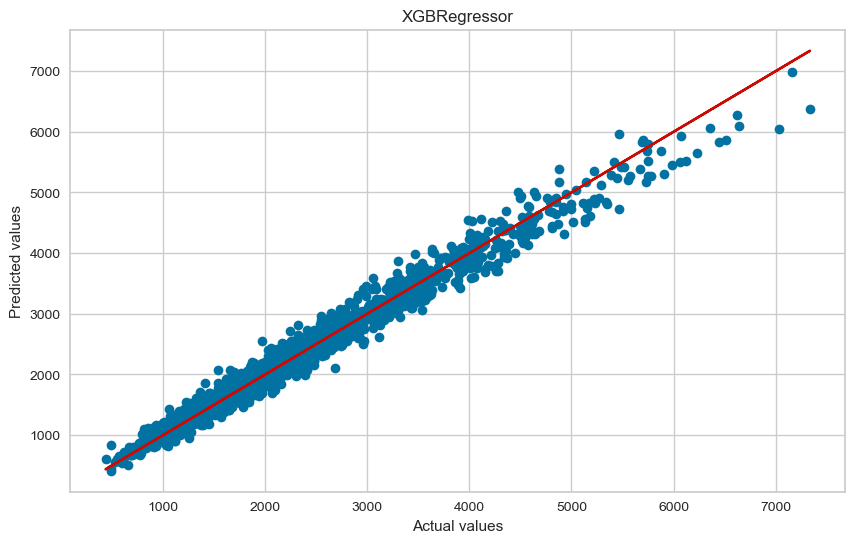

In [81]:
plt.figure(figsize=(10, 6))
plt.plot(y_test, y_pred_xgbr, 'o')
plt.plot(y_test, y_test, 'r')
plt.title("XGBRegressor")
plt.xlabel("Actual values")
plt.ylabel("Predicted values")
plt.show()

### Neural Network

In [82]:
ml_x = df_numeric.drop('CarbonEmission', axis=1).columns
ml_x

Index(['Body Type', 'Sex', 'Diet', 'How Often Shower', 'Heating Energy Source',
       'Transport', 'Vehicle Type', 'Social Activity', 'Monthly Grocery Bill',
       'Frequency of Traveling by Air', 'Vehicle Monthly Distance Km',
       'Waste Bag Size', 'Waste Bag Weekly Count', 'How Long TV PC Daily Hour',
       'How Many New Clothes Monthly', 'How Long Internet Daily Hour',
       'Energy efficiency', 'Recycling', 'Cooking_With'],
      dtype='object')

In [83]:
ml_x = df_numeric.drop('CarbonEmission', axis=1).values
ml_y = df_numeric['CarbonEmission'].values

scaler = StandardScaler()
y = ml_y
x = scaler.fit_transform(ml_x)
print(x)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

[[ 0.43836579 -0.99860098 -0.44178656 ... -1.24866823 -1.19724004
   1.19684541]
 [-0.45516416 -0.99860098  1.35445885 ... -1.24866823 -1.19724004
   0.32412745]
 [ 0.43836579  1.00140098 -1.33990926 ... -0.01175072 -1.19724004
  -0.54859051]
 ...
 [ 0.43836579 -0.99860098  1.35445885 ...  1.2251668   0.0989185
  -1.42130847]
 [ 1.33189575  1.00140098  0.45633615 ... -0.01175072 -0.54916077
   0.10594796]
 [-0.45516416  1.00140098 -0.44178656 ... -0.01175072  0.74699777
  -0.98494949]]


In [84]:
# Save scaler
with open('models/scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

In [85]:
# Create model for neural network:
# Selecting input shape, and defining number of layers & neurons
model = keras.Sequential([
    keras.layers.Input(shape=(19,)),             # 19 feature / input neurons
    
    keras.layers.Dense(256, activation='relu'),  # Hidden layer with 32 neurons and ReLU activation
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(512, activation='relu'),

    keras.layers.Dense(1)                        # Output layers
])

In [86]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               5120      
                                                                 
 dense_1 (Dense)             (None, 512)               131584    
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dense_3 (Dense)             (None, 512)               262656    
                                                                 
 dense_4 (Dense)             (None, 1)                 513       
                                                                 
Total params: 662529 (2.53 MB)
Trainable params: 662529 (2.53 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [87]:
# Compile the model
model.compile(optimizer='adam', loss='mean_absolute_error')

In [88]:
# Train the model
model.fit(X_train, y_train, epochs=50)

Epoch 1/50

250/250 [==============================] - 4s 7ms/step - loss: 631.9645
Epoch 2/50
250/250 [==============================] - 2s 7ms/step - loss: 334.7746
Epoch 3/50
250/250 [==============================] - 2s 7ms/step - loss: 288.1886
Epoch 4/50
250/250 [==============================] - 2s 8ms/step - loss: 250.6250
Epoch 5/50
250/250 [==============================] - 2s 7ms/step - loss: 233.4656
Epoch 6/50
250/250 [==============================] - 2s 7ms/step - loss: 212.2164
Epoch 7/50
250/250 [==============================] - 2s 7ms/step - loss: 189.8686
Epoch 8/50
250/250 [==============================] - 2s 7ms/step - loss: 163.5269
Epoch 9/50
250/250 [==============================] - 2s 7ms/step - loss: 150.4564
Epoch 10/50
250/250 [==============================] - 2s 7ms/step - loss: 137.0779
Epoch 11/50
250/250 [==============================] - 2s 7ms/step - loss: 129.6750
Epoch 12/50
250/250 [==============================] - 2s 7ms/step - loss: 118.6483


In [89]:
t_loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {t_loss:.2f}")

63/63 [==============================] - 0s 4ms/step - loss: 115.1023
Test Loss: 115.10


In [90]:
pred = model.predict(X_test)
print(r2_score(y_test, pred))

63/63 [==============================] - 0s 3ms/step
0.979972816363748


In [91]:
pred

array([[1403.6957],
       [2287.3687],
       [1469.2327],
       ...,
       [2212.8196],
       [2175.4775],
       [2257.2908]], dtype=float32)

In [92]:
pickle.dump(model, open('./models/nn_model.pkl', 'wb')) 

### Neural Network Results

 [x1,... xn] means the numbers of neurons for each layer in the network

<table><tr>
<td>

|Layers                      | Epochs | Accuracy | Test Loss | MAE     |
|----------------------------| -------| -------- | ----------| --------|
|1 lay [32]                  | 50     | 0.6514   | 485.4101  | 488.3452|
|1 lay [64]                  | 50     | 0.6794   | 458.6350  | 457.2778|
|1 lay [128]                 | 50     | 0.7634   | 360.0965  | 358.2312|
|1 lay [256]                 | 50     | 0.8073   | 314.0002  | 303.8010|
|1 lay [512]                 | 50     | 0.8387   | 277.7811  | 267.3893|


</td><td>

|Layers                      | Epochs | Accuracy | Test Loss | MAE     |
|----------------------------| -------| -------- | ----------| --------|
|2 lay [32, 64]              | 50     | 0.8260   | 305.7189  | 287.4525|
|2 lay [64, 128]             | 50     | 0.8519   | 280.6377  | 259.1389|
|2 lay [128, 256]            | 50     | 0.9222   | 195.7561  | 177.1057|
|2 lay [256, 512]            | 50     | 0.9588   | 154.8777  | 133.3263|

</td></tr>

<tr>
<td>

|Layers                      | Epochs | Accuracy | Test Loss | MAE     |
|----------------------------| -------| -------- | ----------| --------|
|3 lay [32, 64, 128]         | 50     | 0.8919   | 219.7377  | 210.3670|
|3 lay [64, 128, 256]        | 50     | 0.9469   | 167.5058  | 152.9221|
|3 lay [128, 256, 512]       | 50     | 0.9755   | 126.4031  | 104.1510|
|3 lay [256, 512, 512]       | 50     | 0.9800   | 115.4065  | 81.7558 |

</td><td>

|Layers                      | Epochs | Accuracy | Test Loss | MAE     |
|----------------------------| -------| -------- | ----------| --------|
|4 lay [32, 64, 128, 256]    | 50     | 0.9787   | 117.9240  | 108.2563|
|4 lay [64, 128, 256, 512]   | 50     | 0.9792   | 117.7210  | 94.6650 |
|4 lay [128, 256, 512, 512]  | 50     | 0.9713   | 134.8475  | 80.8660 |
|4 lay [256, 512, 512, 512]  | 50     | 0.9819   | 109.2275  | 75.5905 |

</td></tr></table>

<!-- |19 lay [all 32] | 50     | 0.974    | 126.68 | v| -->

NB: Source used for helping to make this neural network: [Neural Network Regression Implementation and Visualization in Python](https://medium.com/@nandiniverma78988/neural-network-regression-implementation-and-visualization-in-python-d5893713ed79)

#### Approach (simple model)

The approach was to start with a simple model, and then add complexity over time to try to increase the accuracy of the model. At the beginning, we chose to start with only one hidden layer and 32 neurons, and then each time increase neurons with the power of 2. We made the assumption that the max number of neurons in a layer should be 512 to avoid overfitting, beacuse we know that more neurons means that the model has a higher capacity to learn form the traning data; however we dont want the model to learn from noise and other irrelevant factors, which can lead to overfitting.

#### Configuration

The 4 performance metrics of the neural network with varying configurations over 50 epochs of layers and neurons are shown in the table above. This config are defined by the number of layers and the number of neurons in each layer. For all iterations, we chose the activations function: ReLU:
```math
f(x) = max(0, x)
```

#### Results

The results show that the accuracy of the model increases with the number of layers and neurons. We can see that the accuracy of the model is 0.9819 with 4 layers (256, 512, 512, 512 neurons) The test loss is 109.2275 and the mean absolute error is 75.5905. This is the best result we have achieved with the neural network.
We can also conclude that the neural network has better results the our XGBoost model, that 'only' got an accuracy of 0.9747 and a MAE of 123.9864.


#### Alterantive improvements

Without a doubt, we know that our neural network has a good accuracy 0.9819 and a littel MAE on 75.5905. However, we can still alot of different was to try and improve the model.
The different tings that can be experimaneted with are the following:
- The number of epochs
- The number of layers
- The number of neurons in each layer
- The activation function

## Unsupervised machine learning

### Applying the data to K-means, Hierarchical clustering & Mean Shift

The perpose of applying these clustering models, is to see if, there are patterns in the data, that we haven't been able to see before.

In [124]:
scaler = StandardScaler()

# Create an instance of PCA
pca = PCA(n_components=2)

X_scaled = scaler.fit_transform(df_numeric)

# Fit the PCA model to the data
X_pca = pca.fit_transform(X_scaled)

# Create a new DataFrame with the PCA results
df_numeric_pca = pd.DataFrame(X_pca, columns=[f'PC{i}' for i in range(1, pca.n_components_ + 1)])
df_numeric_pca


,PC1,PC2
0,-0.776786,-0.980838
1,-1.496961,0.377828
2,2.069319,-0.428529
3,-1.831997,-0.870499
4,2.906289,0.059497
...,...,...
9995,1.151171,0.146264
9996,2.489657,-1.322963
9997,-1.171762,-0.161853
9998,4.156237,-0.167465


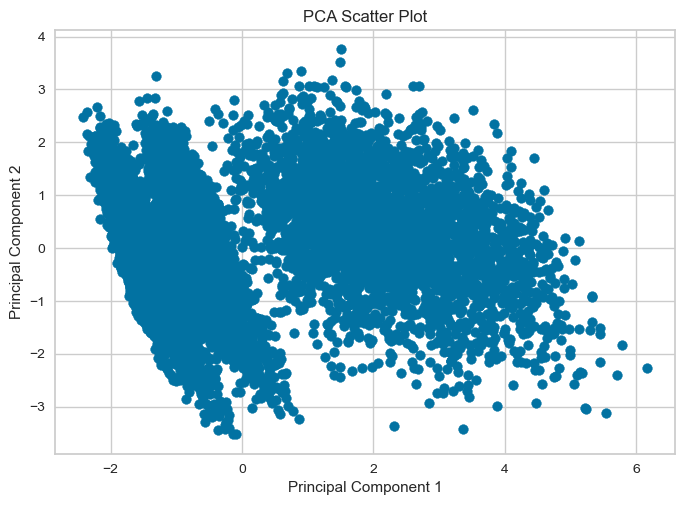

In [122]:
# Create a scatter plot of the first two principal components
plt.scatter(X_pca[:, 0], X_pca[:, 1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Scatter Plot')
plt.show()


In [117]:
X = df_numeric_pca.values
X

array([[-0.76838282],
       [-1.49567798],
       [ 2.06095288],
       ...,
       [-1.17361561],
       [ 4.14706786],
       [ 1.70228515]])

### Hierarchical clustering

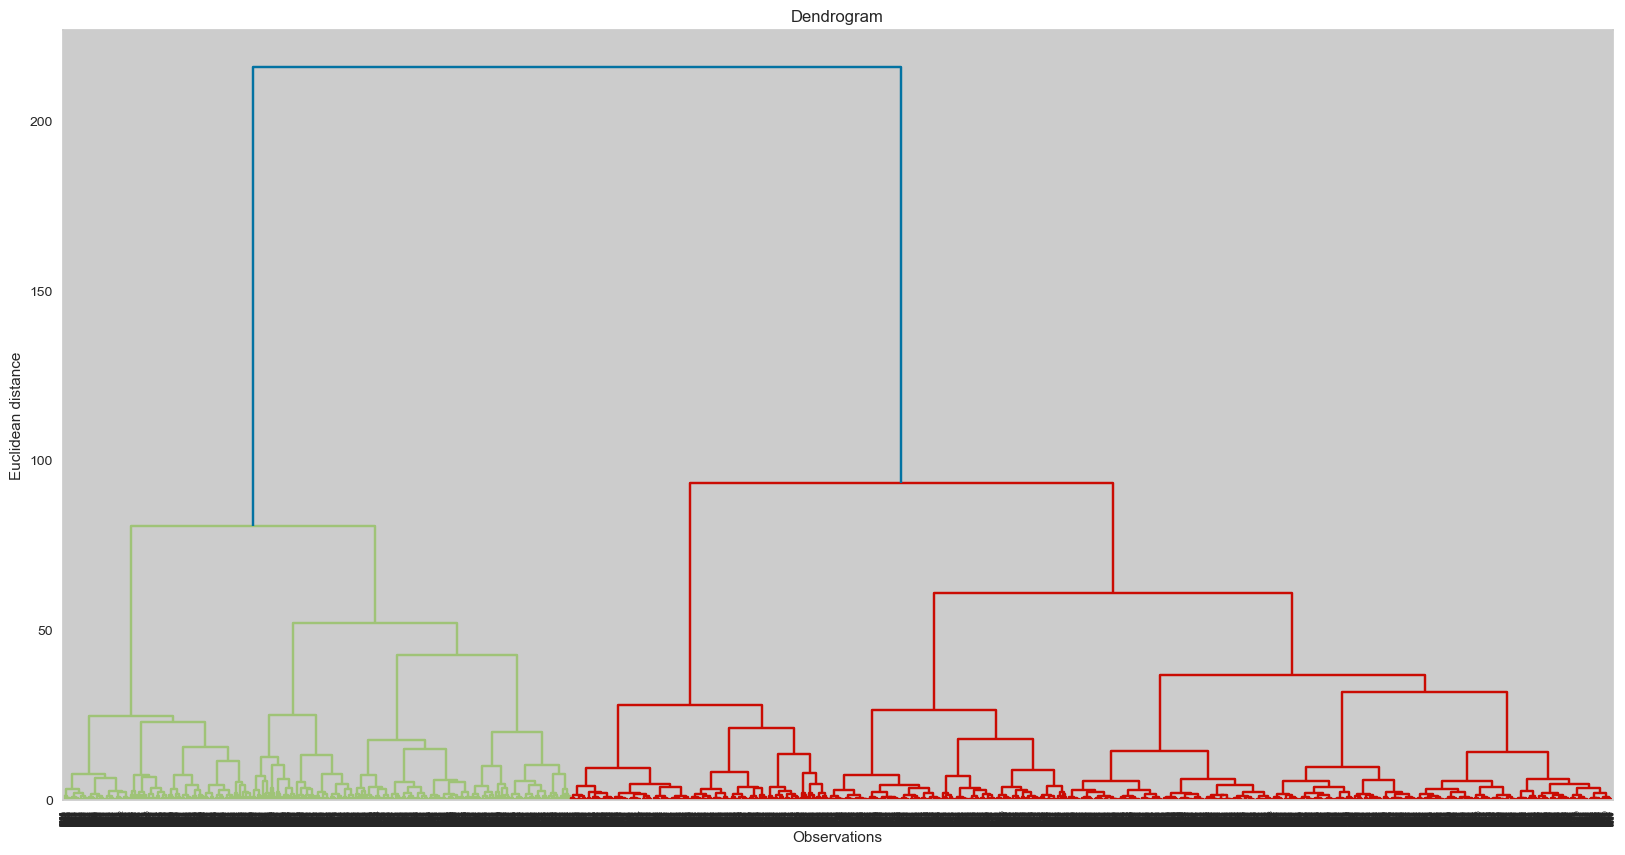

In [98]:
# Making the dendrogram to find the optimal number of clusters
plt.figure(figsize=(20,10))

dendogram = ch.dendrogram(ch.linkage(X, method = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Observations')
plt.ylabel('Euclidean distance')
plt.show()

In [99]:
# Hierarchical Clustering Model
n_clusters = 2
model = AgglomerativeClustering(n_clusters, affinity = 'euclidean', linkage = 'ward')
model.fit(X)

AgglomerativeClustering(affinity='euclidean')

In [100]:
Y = model.fit_predict(X)
Y

array([0, 0, 1, ..., 0, 1, 1], dtype=int64)

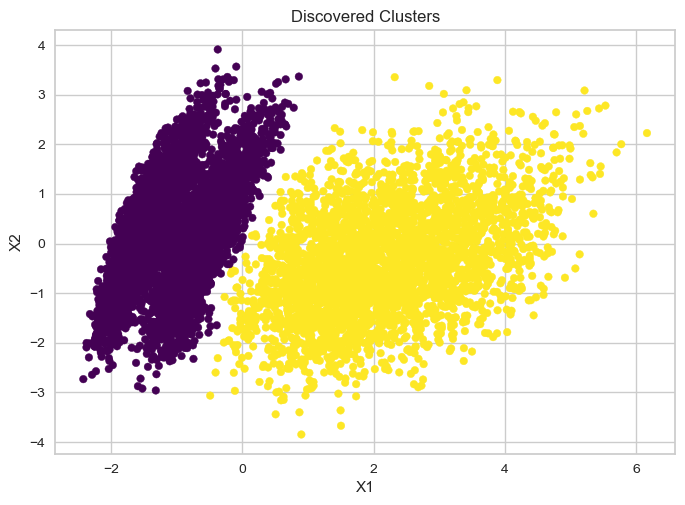

In [101]:
# Visualising the clusters
plt.scatter(X[:, 0], X[:, 1], s=30, c=Y, cmap='viridis')
plt.title('Discovered Clusters')
plt.xlabel('X1')
plt.ylabel('X2')
# plt.legend()
plt.show()

In [102]:
hc = model.fit_predict(X)
print("Hierarchical Silhouette Score:", silhouette_score(X, hc))

Hierarchical Silhouette Score: 0.5411706752029517


### K-means

In [103]:
# KMeans Clustering Model
# Extracting the features
X_kmeans = X
X_kmeans

array([[-0.76787071, -0.83985893],
       [-1.49250802,  0.18353391],
       [ 2.06114508, -0.51690163],
       ...,
       [-1.17457198,  0.85182965],
       [ 4.14472349,  0.13960007],
       [ 1.70002726, -2.2361513 ]])

In [104]:
# Using the elbow method to find the optimal number of clusters
distortions = []
K = range(2,10)
for k in K:
    model = KMeans(n_clusters=k, n_init=10).fit(X_kmeans)
    model.fit(X_kmeans)
    distortions.append(sum(np.min(cdist(X_kmeans, model.cluster_centers_, 'euclidean'), axis=1)) / X_kmeans.shape[0]) 
print("Distortion: ", distortions)

Distortion:  [1.1598932337814034, 0.9466409884234266, 0.8266335324196518, 0.7510217411450368, 0.7072712871810195, 0.670261682602816, 0.6081394625302403, 0.5759758406271976]


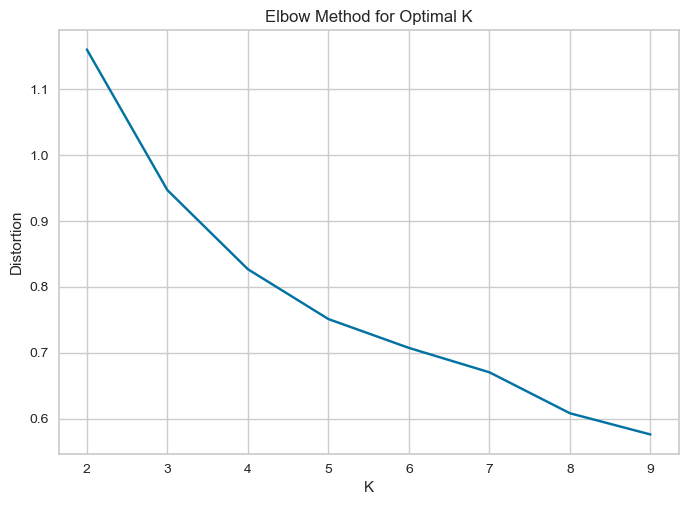

In [105]:
# Plotting the elbow method
plt.title('Elbow Method for Optimal K')
plt.plot(K, distortions, 'bx-')
plt.xlabel('K')
plt.ylabel('Distortion')
plt.show()

In [106]:
k_clusters = 4

In [107]:
kmeans = KMeans(init='k-means++', n_clusters=k_clusters, n_init=20)

In [108]:
kmeans.fit(X_kmeans)

KMeans(n_clusters=4, n_init=20)

In [109]:
# Silhouette score for KMeans clustering for different number of clusters
scores = []
K = range(2, 10)
for k in K:
    model = KMeans(n_clusters=k, n_init=10)
    model.fit(X_kmeans)
    score = metrics.silhouette_score(X_kmeans, model.labels_, metric='euclidean', sample_size=len(X_kmeans))
    print("\nNumber of clusters =", k)
    print("Silhouette score =", score)
    scores.append(score)


Number of clusters = 2
Silhouette score = 0.5488917956370712

Number of clusters = 3
Silhouette score = 0.42672380897187623

Number of clusters = 4
Silhouette score = 0.4191776977927664

Number of clusters = 5
Silhouette score = 0.365469081286231

Number of clusters = 6
Silhouette score = 0.34971891023349044

Number of clusters = 7
Silhouette score = 0.35837627790577953

Number of clusters = 8
Silhouette score = 0.3741614071657182

Number of clusters = 9
Silhouette score = 0.35583584864237844


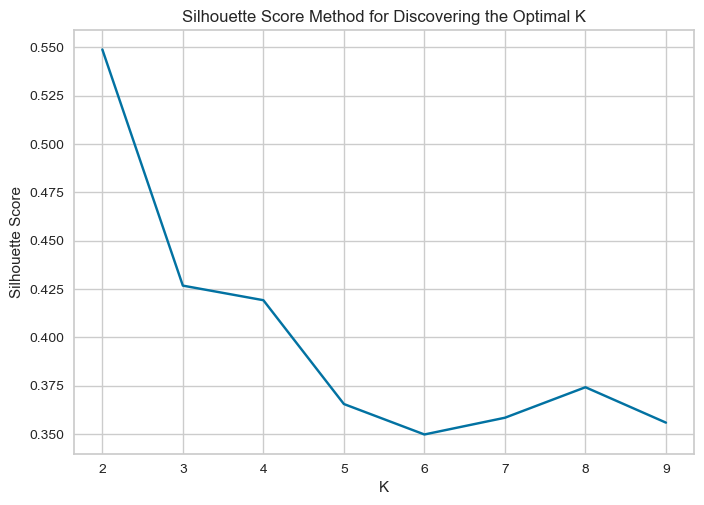

In [110]:
# Plot the elbow
plt.title('Silhouette Score Method for Discovering the Optimal K')
plt.plot(K, scores, 'bx-')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.show()

In [111]:
y = kmeans.predict(X_kmeans)
y

array([1, 1, 3, ..., 0, 2, 3])

In [112]:
print(kmeans.labels_)

[1 1 3 ... 0 2 3]


Cluster  0 :  (3219, 2)


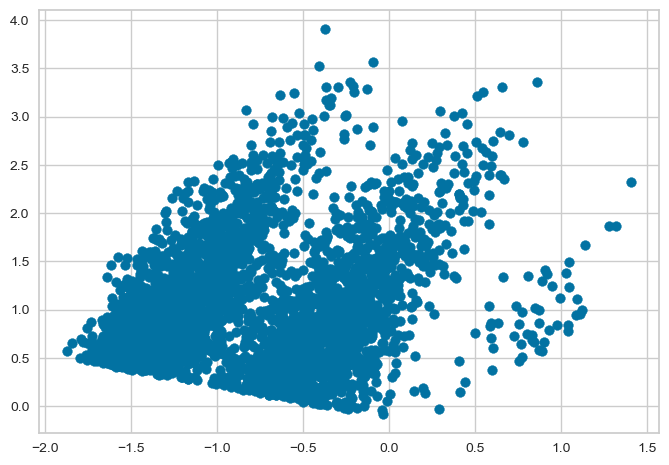

Cluster  1 :  (3592, 2)


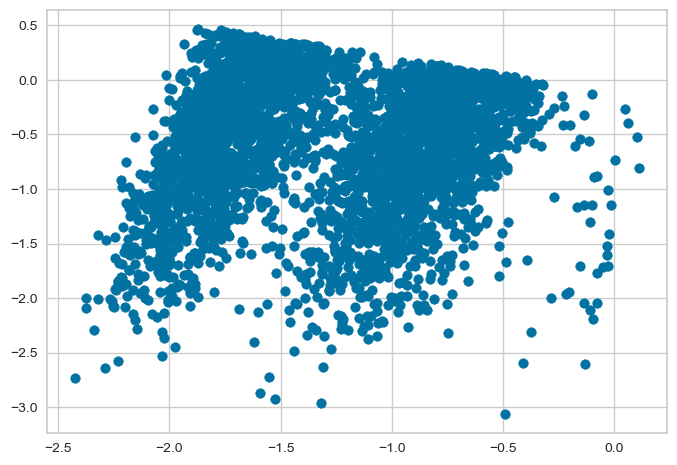

Cluster  2 :  (1371, 2)


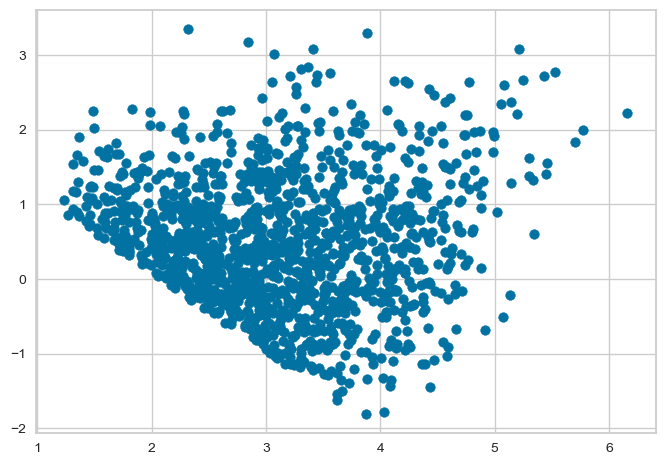

Cluster  3 :  (1818, 2)


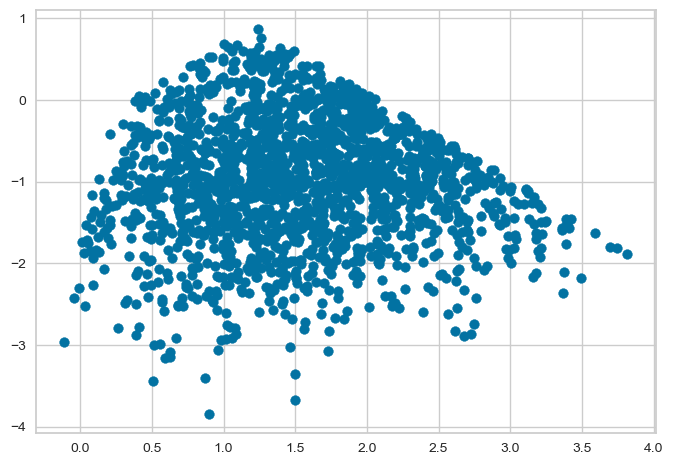

In [113]:
# Visualising the endividual clusters
for i in range(k_clusters):
    # slice the cluster
    cluster = X_kmeans[y == i]    
    # print the shape
    print("Cluster ", i, ": ", cluster.shape)    
    # plot the points of this cluster
    plt.scatter(cluster[:, 0], cluster[:, 1])   
    plt.grid(True)
    plt.show()

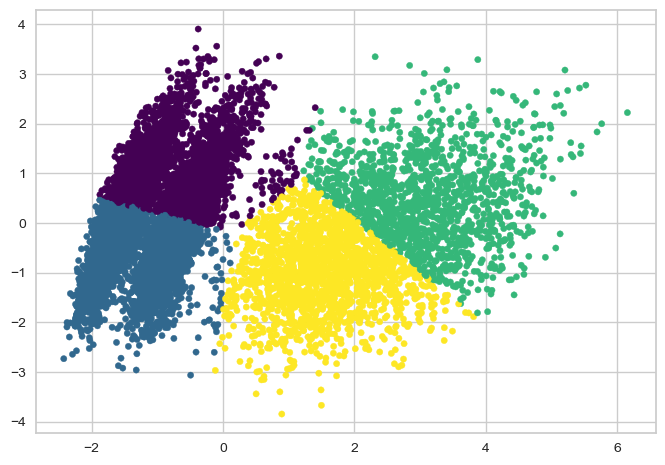

In [114]:
# Visualising all the clusters
plt.scatter(X_kmeans[:, 0], X_kmeans[:, 1], c=y, s=20, cmap='viridis')
plt.grid(True)
plt.show()

In [115]:
print(kmeans.cluster_centers_)

[[-0.74023394  1.06039444]
 [-1.29352966 -0.62446239]
 [ 3.1139048   0.50180287]
 [ 1.52416598 -1.00753898]]


In [116]:
k = 5
model = KMeans(n_clusters=k, n_init=10)
model.fit_predict(X_kmeans)

array([2, 4, 3, ..., 4, 1, 3])

In [117]:
score = silhouette_score(X_kmeans, model.labels_, metric='euclidean')
print('Silhouette Score: %.3f' % score)

Silhouette Score: 0.366


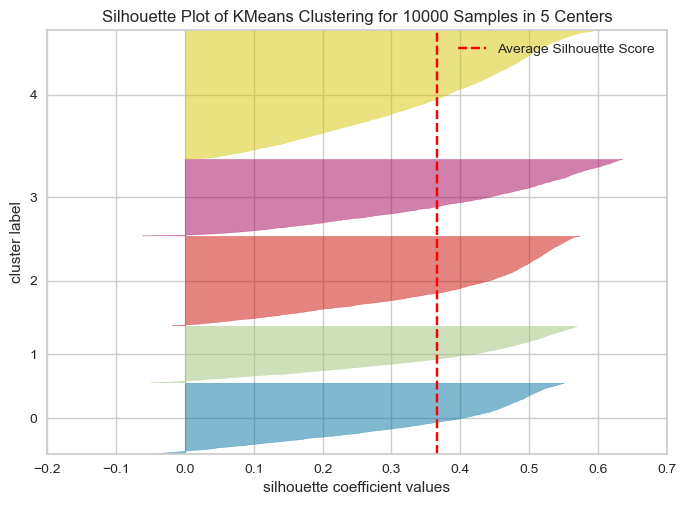

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 10000 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [118]:
# Visualizing the Silhouette Score
visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
visualizer.fit(X_kmeans)
visualizer.show()  

### Mean Shift

In [119]:
# Extracting the features
x_ms = X

In [120]:
# Estimate the bandwidth of the data
bandwidth = estimate_bandwidth(x_ms, quantile=0.2, n_samples=200)
bandwidth 

1.3614172057192355

In [121]:
# Making the instance of the MeanShift model
msmodel = MeanShift(bandwidth=bandwidth, bin_seeding=True)
msmodel.fit(x_ms)

MeanShift(bandwidth=1.3614172057192355, bin_seeding=True)

In [122]:
# Getting the labels
labels = msmodel.labels_
labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)
n_clusters_

2

In [123]:
cluster_centers = msmodel.cluster_centers_
cluster_centers
# Predict the cluster for all the samples
Y = msmodel.predict(x_ms)
Y

array([0, 0, 1, ..., 0, 1, 1], dtype=int64)

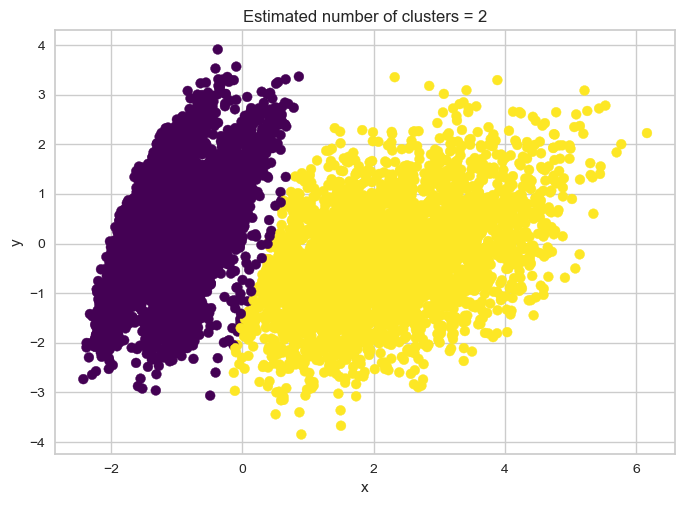

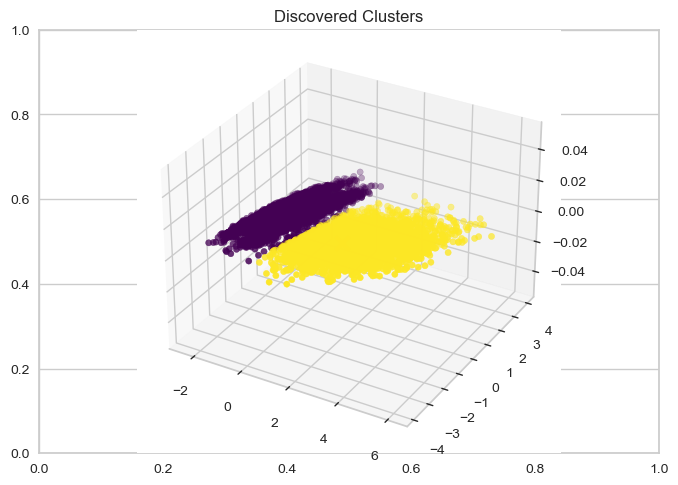

In [124]:
len(msmodel.labels_)

plt.scatter(x_ms[:,0], x_ms[:,1], s=50, c=labels, cmap='viridis')
plt.title(f'Estimated number of clusters = {n_clusters_}')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Visualising the clusters in 3D
df_3d = pd.DataFrame(x_ms, columns=['x', 'y'])
df_3d['label'] = labels

# Create a 3D scatter plot
fig = px.scatter_3d(df_3d, x='x', y='y', z='label', color='label', symbol='label')
fig.show()

fig = plt.figure()
plt.title('Discovered Clusters')
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_ms[:,0], x_ms[:,1],  marker='o', cmap='viridis', c=labels)
ax.scatter(cluster_centers[:,0], cluster_centers[:,1], marker='x', 
           color='red', s=100, linewidth=3, zorder=10)
plt.show()

In [125]:
# Silhouette score for MeanShift clustering
score = silhouette_score(x_ms, msmodel.labels_, metric='euclidean')
print('Silhouette Score: %.3f' % score)

Silhouette Score: 0.545


## Conclusion

Theres much interesing information in exploring this dataset, and we can definetely find a lot of patterns that is crucial for identifying which personal lifestyle factors are significant when it comes to calculationg our total carbon emission output.

**Here is our discoveries summarized:**

- The most significant factors for an individuals carbon emission seem to be their choice of transport. People that drive many kilometers monthly in personal vehicles are also the one who have a tendency to have the highest carbon emissions.

- Theres a small indication that internet usage has an impact on carbon emissions to correlating factors, but no direct pattern can be concluded, so we deem it as insignificant

- There seem to be very little difference in the correlating factors between males and females

- People who see themselves as 'Energy efficient' only seem the emit about 1,5% less carbon than people who say they're 'Not energy efficient', which we conclude makes it insignificant

- People who travel with airplanes very frequently seem to emit around 22% more carbon on average, than people who never fly

#### Prediction by classification
We tried to use different classification machine learning methods to try and predict carbon output based on correlating factors, and clustering methods for trying to discov hidden patterns in the data.

For classification we tried:

- Naive Bayes classifier
- Decision Tree classifier
- Random Forest classifier

We tried several iterations for optimizing the models by adjusting the category amount and the normalisation of the input data. The RFC model was the most succesful, with an accuracy of aaround 92% with 3 categories. However, we deem the result as unsaticfactory, since the input data still is a bit unsuited for this kind of machine learning, with 92% of the data fitting into a single category. The good accuracy is due to overfitting.

On the last iteration we tried to divide the categories by quantiles, which made the model drop to 67% accuracy, but is a way more useful and less overfitted model.
We therefore conclude the best classification model to be the RFC model with training data binned into 4 categories based on the quartiles of the data, since it could make decently accurate predictions, and represent the tendencies in the data without being overfitted to the training data. However, this kind of model is definetely unsuited for this task. Even though we got satisfactory predictions, the information value of the predictions are very low, since the binning of the results into categories, makes the prediction results vague and without meaning.

#### Prediction by regression

Since we are trying to predict numeric values, we thought might prove more valuable to try and predict actual carbon emission values by using regression models.
This turned out to be a way better fit than the classification models, both in accuracy and in the information value of the output.

we used an advanced gradient boosting model for this purpose
in the form of an XGBRegressor.

It was quick to train the model, and
we ended up getting very good results,
wtih an accuracy of 97% on the test set.

A good fit for this data.

#### Clustering summary:

We have try using K-means, Hierarchical clustering, DBSCAN & Mean shift to see if there are any patterns in the data, but it seems that there are no clear patterns in the data, when applying these clustering methods to the hole dataset. We have tried with and without scaling the data. Additionally, we have tried to use different numbers of clusters, but the results are still the same. 
This is concluded based on the visualisation of the clusters from the different methods due to the visualistations being poor; However, the silhouette score have actually been quite high, which indicates that there are some patterns in the data.

Silhouette score (without scaling and pca):
* K-means: 0.727 (with 2 clusters), 0.624 (with 3 clusters)
* Hierarchical clustering: 0.426
* Mean shift: 0.727

When applying scaling and pca to the data, the visualisation of the clusters are much better; however, the silhouette score is lower than without scaling and pca:

Silhouette score (with scaling and pca):
* K-means: 0.549 (2 clusters), 0.426 (3 clusters)
* Hierarchical clustering: 0.542 (2 clusters)
* Mean shift: 0.546 (2 clusters)

We have also tried using only some parts of the datas features, these results are gives som visualisation endication of patterns.
The features used for the clustering are: 'Monthly Grocery Bill', 'Waste Bag Weekly Count', 'How Long TV PC Daily Hour', 'How Many New Clothes Monthly', 'How Long Internet Daily Hour'

Silhouette score (without scaling and pca):
* K-means: 0.79 (with 2 clusters), 0.727 (with 3 clusters)
* Hierarchical clustering: 0.698
* Mean shift: 0.597

Other features combinations have also been tried, but the results gives similar visualisation and silhouette score.